In [ ]:
!pip install -q pytorch-fid

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from google.colab import drive
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid, save_image
from tqdm.notebook import tqdm
device = 'cuda' if torch.cuda.is_available() else 'cpu'



In [3]:
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/sh3_sc6_y32_x32_imgs.npz'

imgs = np.load(file_path, allow_pickle=True, encoding='latin1')
imgs = imgs['imgs']

class AlimDS(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)
    def get_items(self, num_sample):
        real_samples = []
        indexes = torch.randint(0, len(self.data), (num_sample,), dtype=torch.long)
        for i in range(num_sample):
            real_samples.append(self.__getitem__(indexes[i]))
        real_samples = torch.cat(real_samples, 0)
        return real_samples
    def __getitem__(self, idx):
        img = self.data[idx]
        img = img.astype(np.float32)
        img = img.reshape(1, 64, 64)
        img = torch.from_numpy(img)

        return img


Mounted at /content/drive


In [4]:
class CustomEncoder(nn.Module):
    def __init__(self, z_dim=10, nc=3):
        super(CustomEncoder, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(nc, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 256, kernel_size=4),
            nn.ReLU()
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, z_dim*2)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


class CustomDecoder(nn.Module):
    def __init__(self, z_dim=10, nc=3):
        super(CustomDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU()
        )
        self.upconv_layers = nn.Sequential(
            nn.ConvTranspose2d(256, 64, kernel_size=4),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, nc, kernel_size=4, stride=2, padding=1)
        )

    def forward(self, x):
        x = self.fc_layers(x)
        x = x.view(x.size(0), 256, 1, 1)
        x = self.upconv_layers(x)
        return x


class VAE(nn.Module):
    def __init__(self, z_dim=10, nc=1):
        super(VAE, self).__init__()
        self.z_dim = z_dim
        self.encoder = CustomEncoder(z_dim, nc)
        self.decoder = CustomDecoder(z_dim, nc)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        distributions = self.encoder(x)
        mu = distributions[:, :self.z_dim]
        logvar = distributions[:, self.z_dim:]
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

    def reconstruct(self, dataloader, num_sample, batch_size, device):
        num_iter = math.ceil(float(num_sample) / float(batch_size))
        recon_samples = []

        with torch.no_grad():
            for batch in dataloader:
                batch = batch.to(device)
                x_hat, _, _ = self.forward(batch)
                recon_samples.append(x_hat)

        recon_samples = torch.cat(recon_samples, 0)
        return recon_samples[0:num_sample]

    def generate(self, num_sample, batch_size, device):
        num_iter = math.ceil(float(num_sample) / float(batch_size))
        gen_samples = []

        with torch.no_grad():
            for i in range(num_iter):
                z = torch.randn(batch_size, 10).to(device)
                x = self.decoder(z)
                gen_samples.append(x)

        gen_samples = torch.cat(gen_samples, 0)
        return gen_samples[0:num_sample]


In [8]:
custom_dataset = AlimDS(imgs)

batch_size = 64

data_loader = DataLoader(dataset=custom_dataset, batch_size=batch_size, shuffle=True)

vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.0001)
reconstruction_loss = nn.BCEWithLogitsLoss(size_average=False)

load_pth = False
cur_step = 0
mean_vae_loss = 0
mean_recon_loss = 0
mean_kld_loss = 0
display_step = 4000
num_epochs = 500
vae_losses = []
recon_losses = []
kld_losses = []

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


  0%|          | 0/500 [00:00<?, ?it/s]

Step 4000: Vae loss: 237.09256444740205, Reconstruction loss: 217.06021476936345, Kl-divergence loss: 20.032349608317748


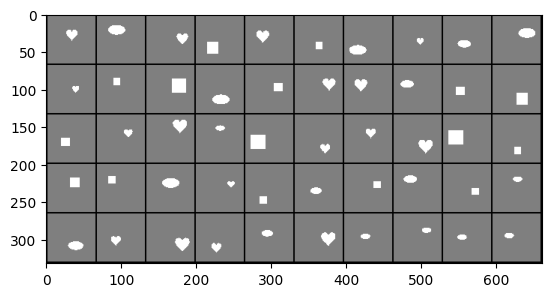

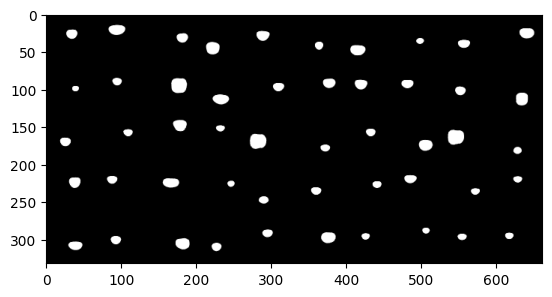

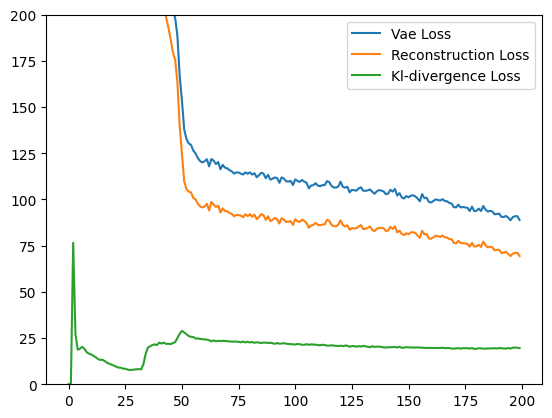

Step 8000: Vae loss: 71.70984868335728, Reconstruction loss: 51.74509767341611, Kl-divergence loss: 19.964750985622388


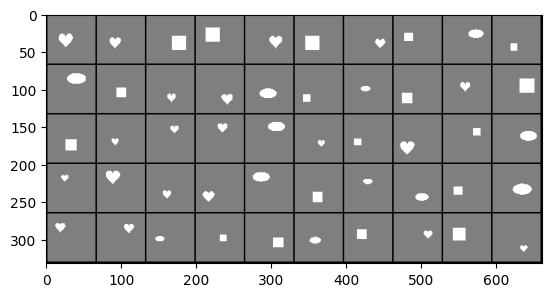

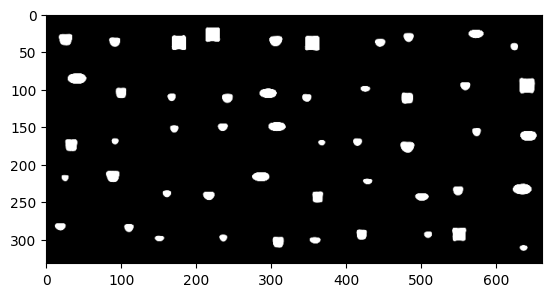

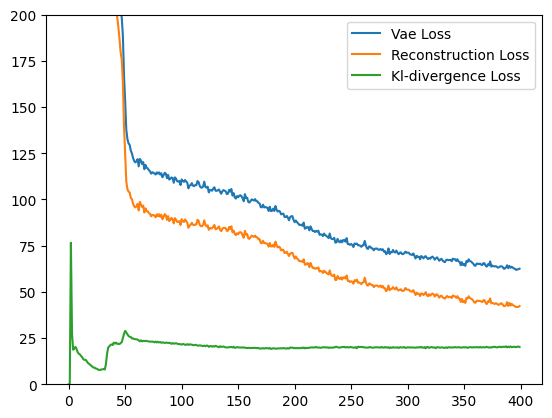

Step 12000: Vae loss: 55.69103149700153, Reconstruction loss: 34.666940082550006, Kl-divergence loss: 21.024091385364514


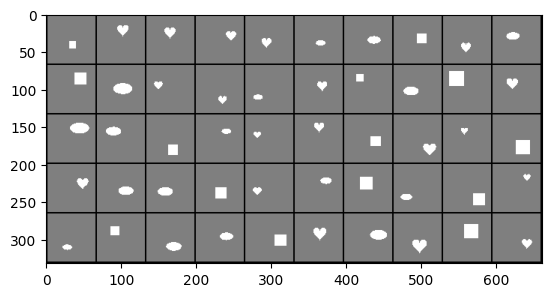

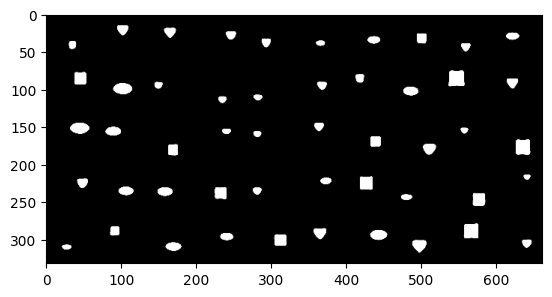

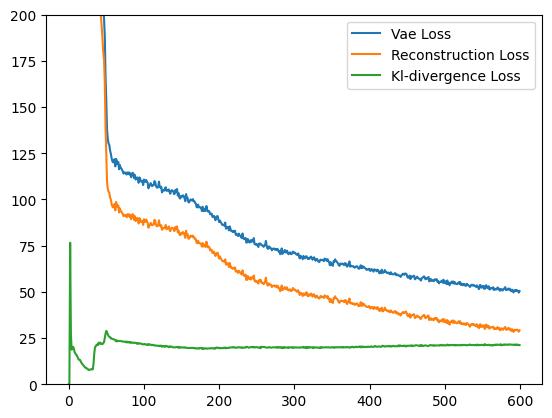

Step 16000: Vae loss: 46.86510961723323, Reconstruction loss: 25.390921614646885, Kl-divergence loss: 21.474187964916233


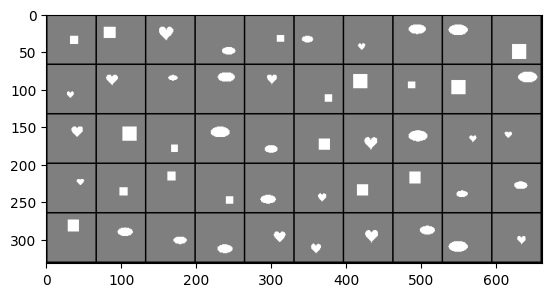

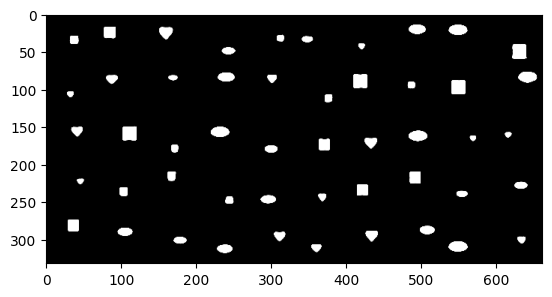

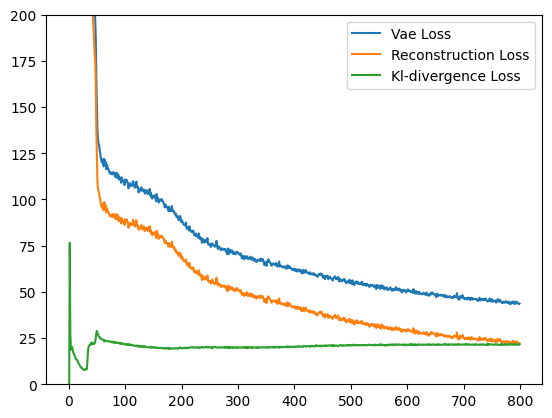

Step 20000: Vae loss: 41.62354792404184, Reconstruction loss: 20.138504353284812, Kl-divergence loss: 21.485043495655063


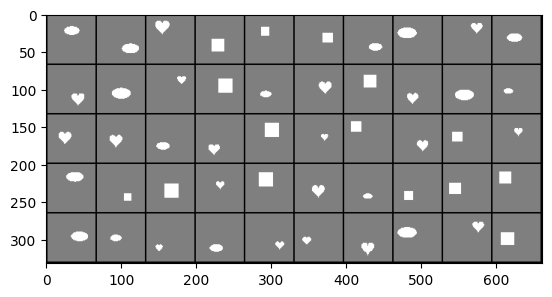

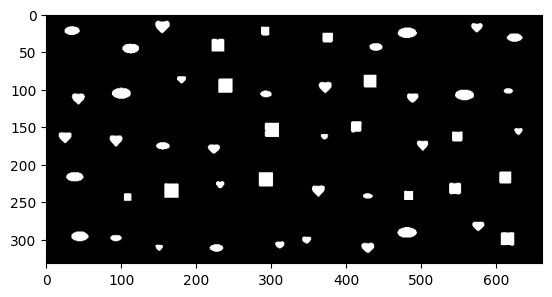

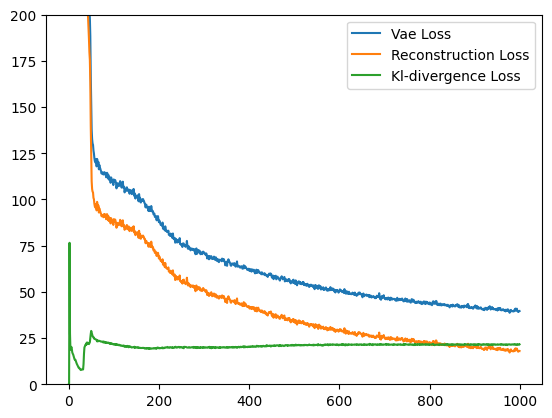

Step 24000: Vae loss: 38.1103064489365, Reconstruction loss: 16.636561992883678, Kl-divergence loss: 21.47374446487425


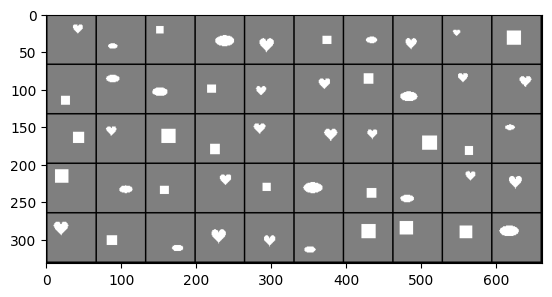

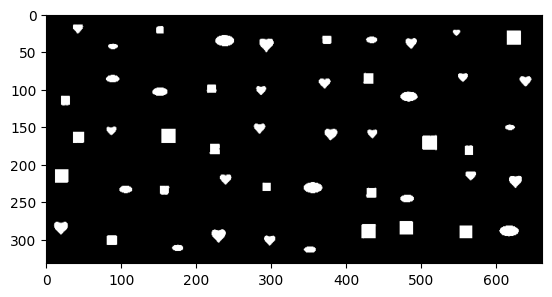

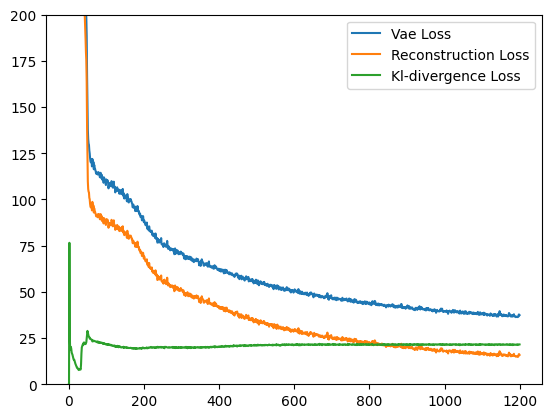

Step 28000: Vae loss: 35.840387679100054, Reconstruction loss: 14.480035070180936, Kl-divergence loss: 21.36035259866713


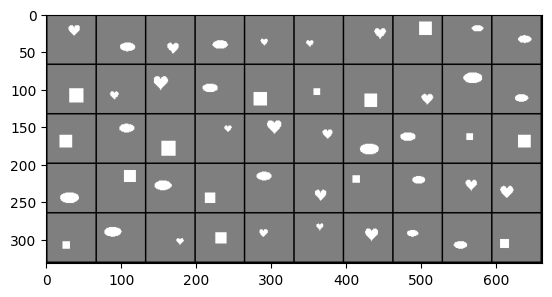

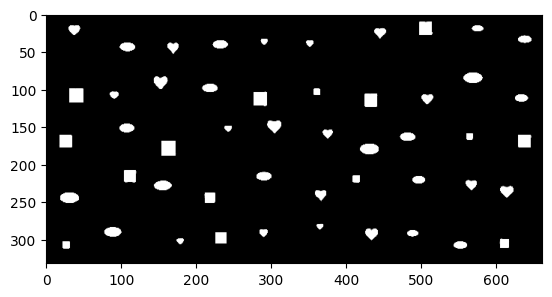

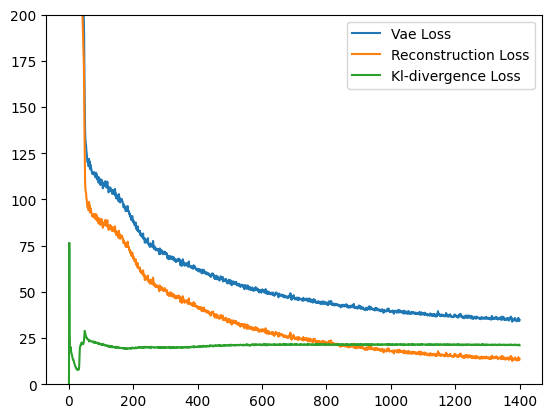

Step 32000: Vae loss: 34.14724570846556, Reconstruction loss: 12.93281817960742, Kl-divergence loss: 21.21442753648751


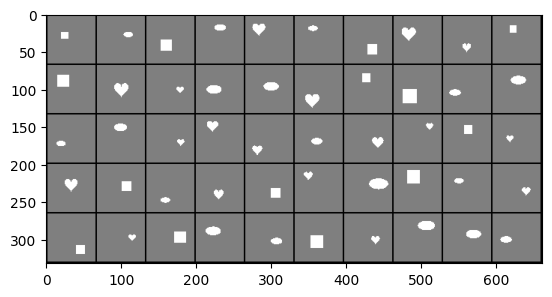

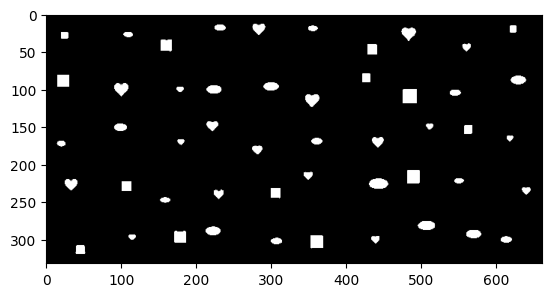

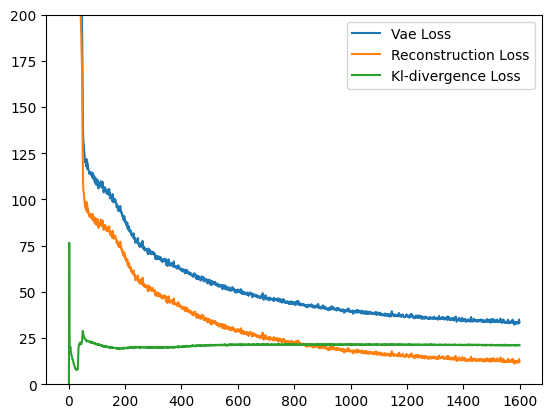

Step 36000: Vae loss: 32.930624890327465, Reconstruction loss: 11.878921415567383, Kl-divergence loss: 21.05170345926286


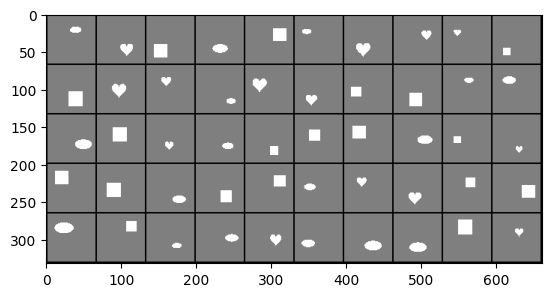

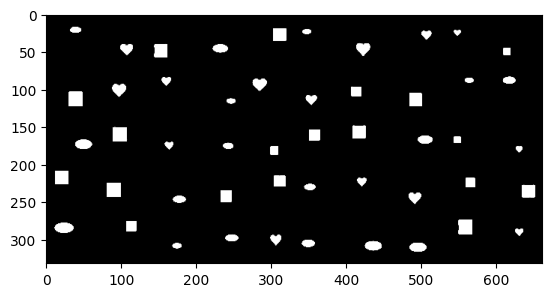

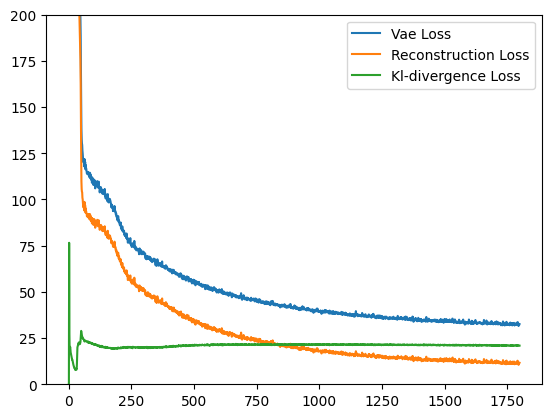

Step 40000: Vae loss: 31.98505989027024, Reconstruction loss: 11.061432604789706, Kl-divergence loss: 20.923627274990125


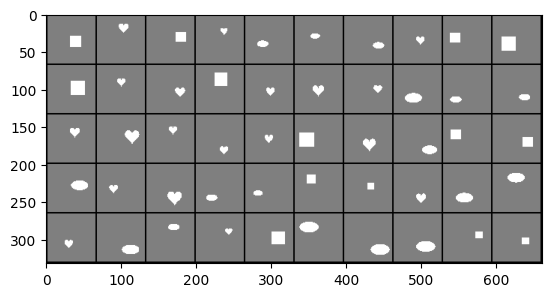

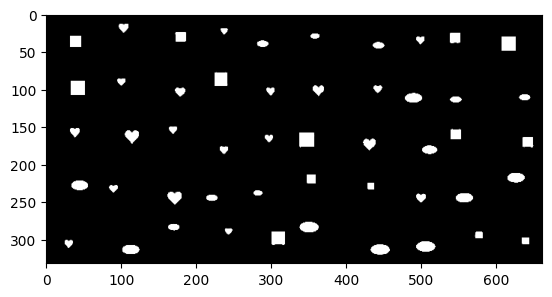

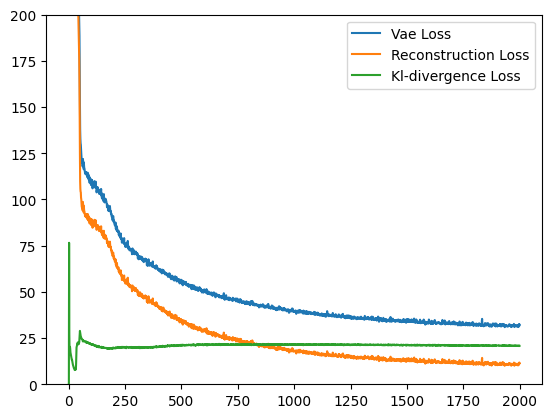

Step 44000: Vae loss: 31.166886436939247, Reconstruction loss: 10.387824482917797, Kl-divergence loss: 20.779061965942404


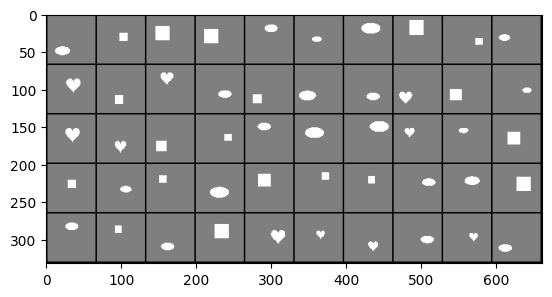

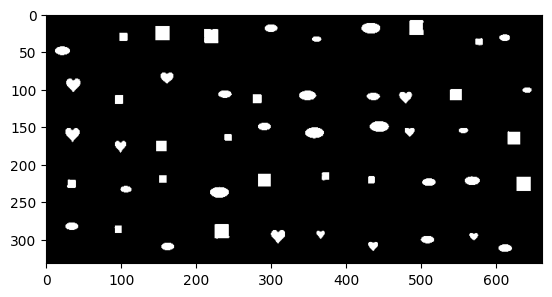

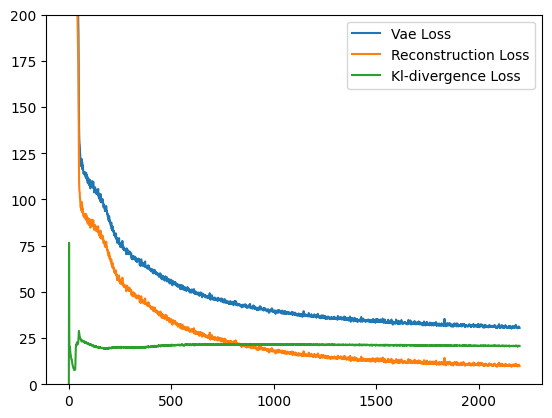

Step 48000: Vae loss: 30.523322107315046, Reconstruction loss: 9.835805312275854, Kl-divergence loss: 20.68751678323753


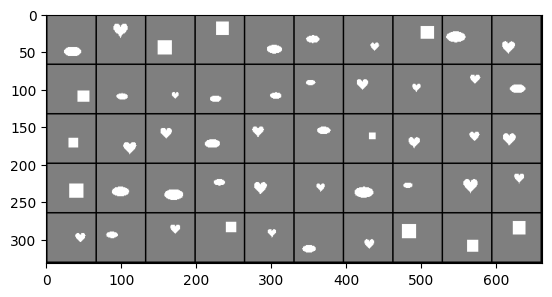

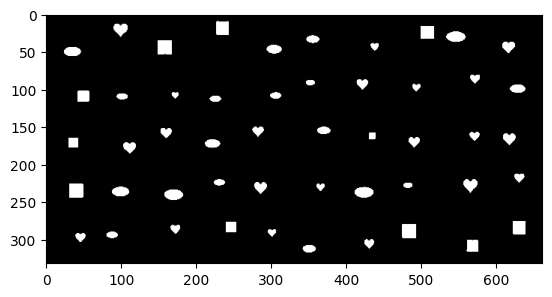

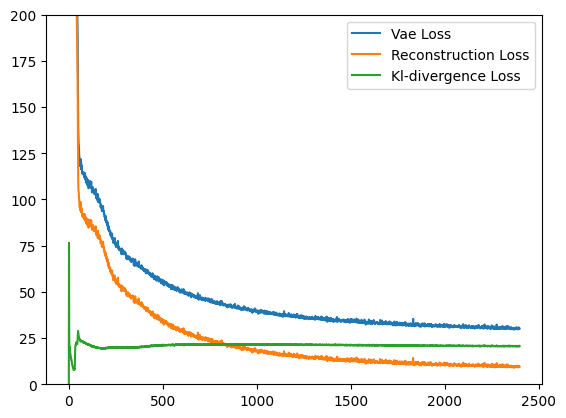

Step 52000: Vae loss: 30.001705031394994, Reconstruction loss: 9.42228200984001, Kl-divergence loss: 20.579423018932346


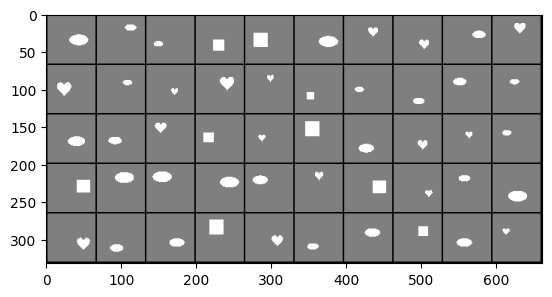

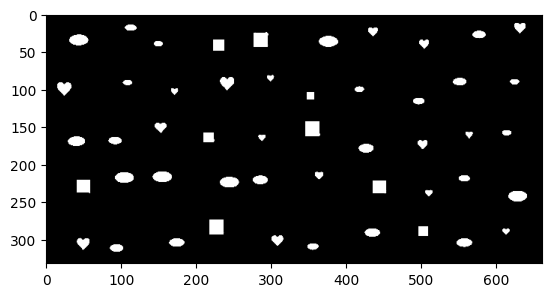

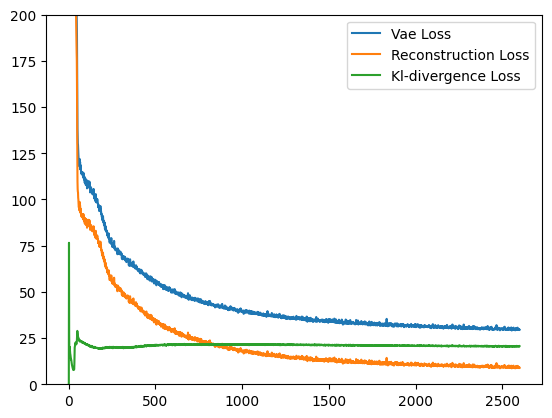

Step 56000: Vae loss: 29.53362633800506, Reconstruction loss: 9.046509412646305, Kl-divergence loss: 20.487116911888123


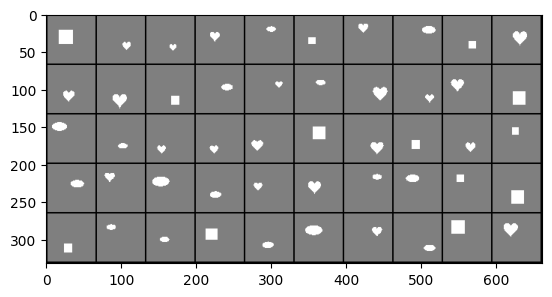

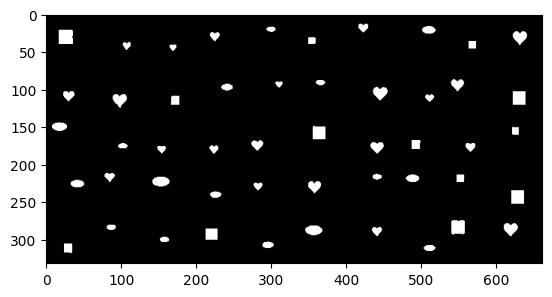

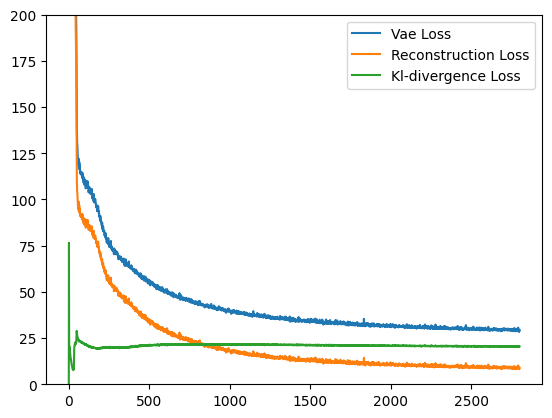

Step 64000: Vae loss: 28.742670062064978, Reconstruction loss: 8.41267574596406, Kl-divergence loss: 20.3299943208694


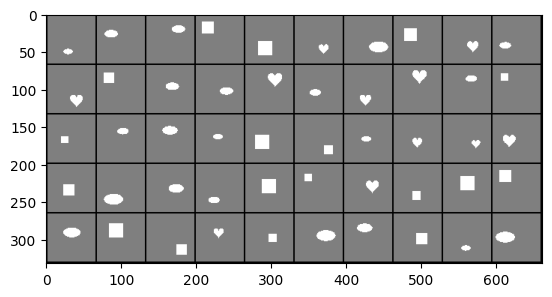

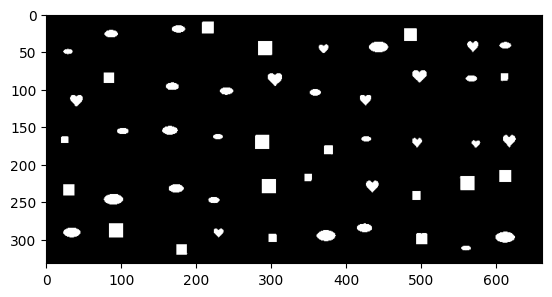

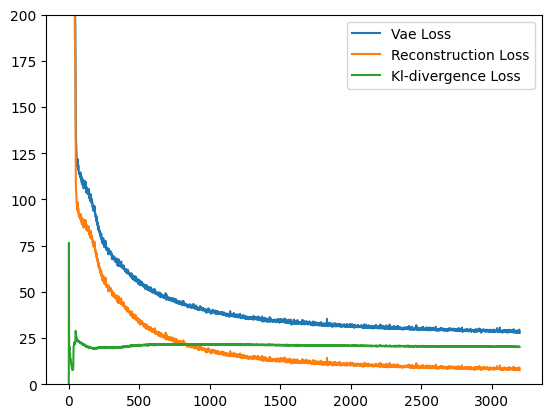

Step 68000: Vae loss: 28.415626968383734, Reconstruction loss: 8.15497217106818, Kl-divergence loss: 20.260654783725723


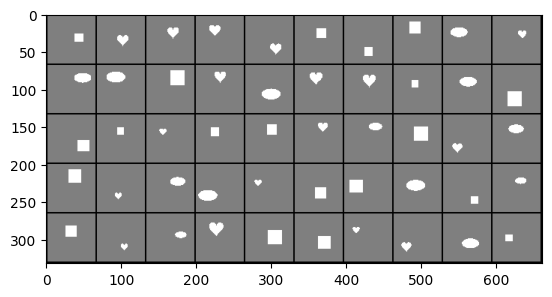

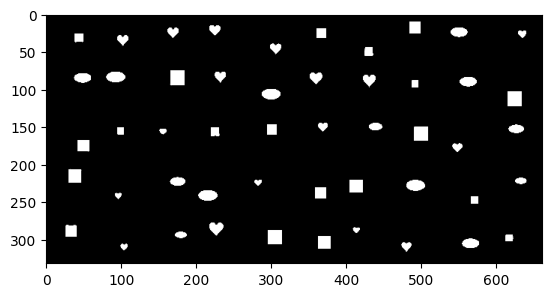

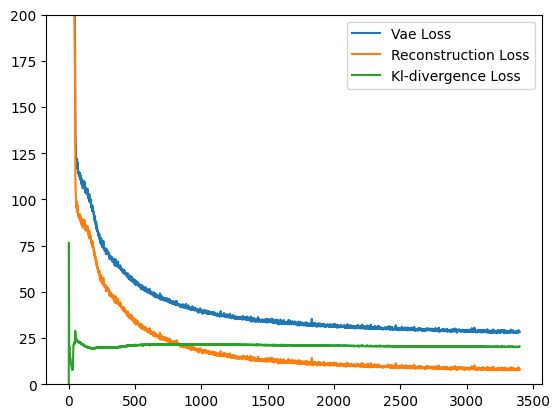

Step 72000: Vae loss: 28.12195903539661, Reconstruction loss: 7.94019150662423, Kl-divergence loss: 20.18176754379276


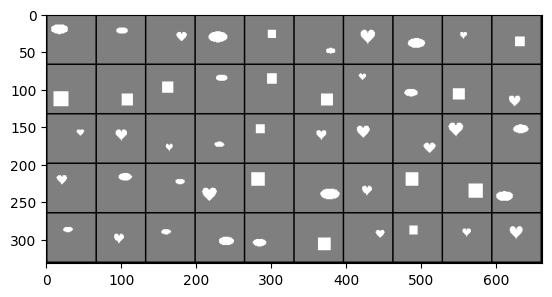

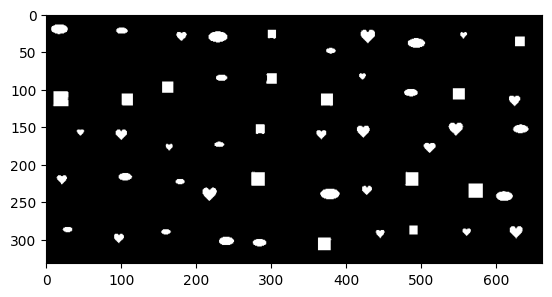

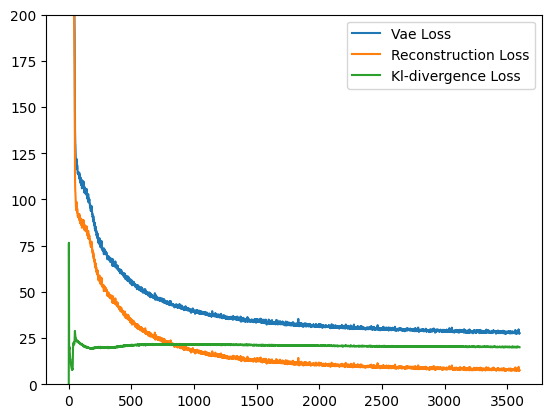

Step 76000: Vae loss: 27.801115561008462, Reconstruction loss: 7.690163346409812, Kl-divergence loss: 20.110952210426294


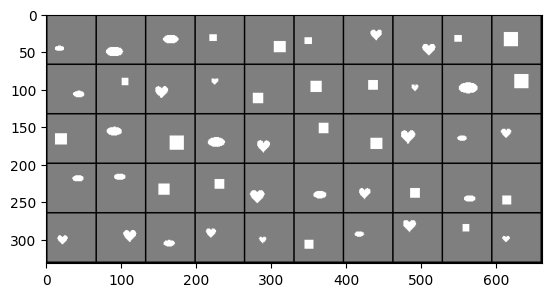

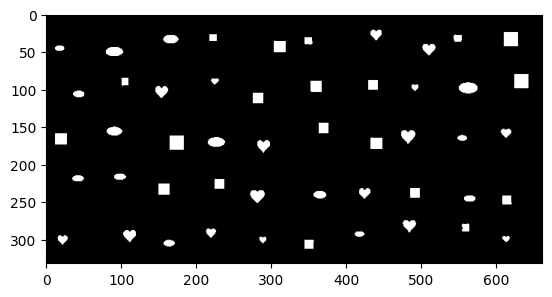

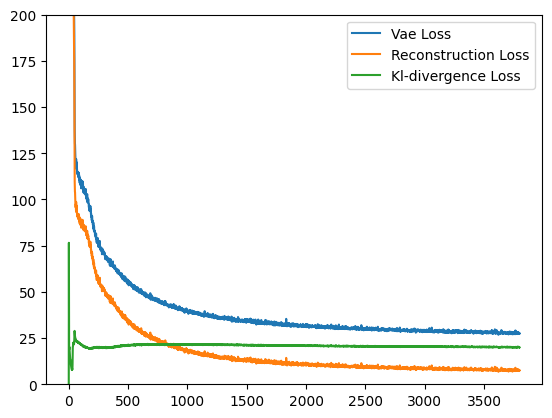

Step 80000: Vae loss: 27.580149707317403, Reconstruction loss: 7.5319324228763564, Kl-divergence loss: 20.048217281818374


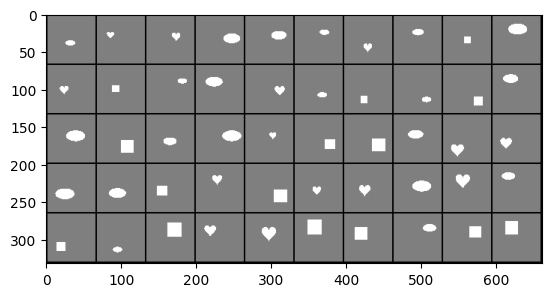

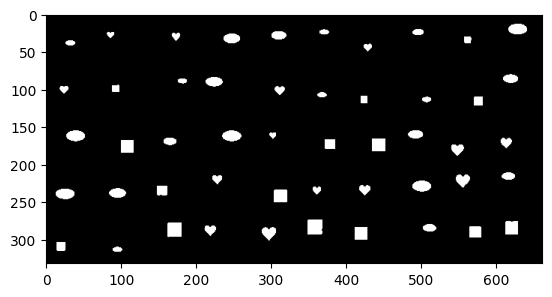

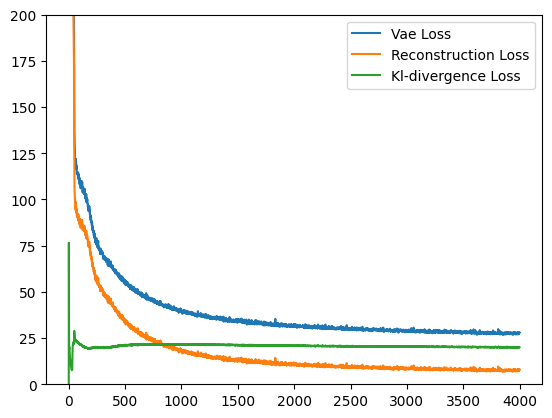

Step 84000: Vae loss: 27.35439242839815, Reconstruction loss: 7.388572462916363, Kl-divergence loss: 19.965819976329808


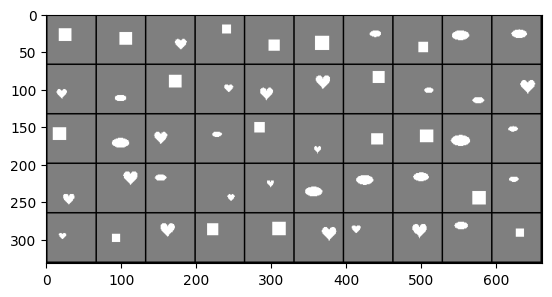

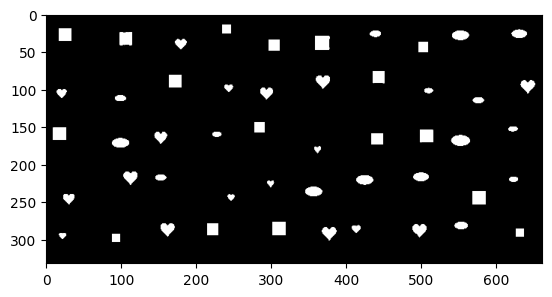

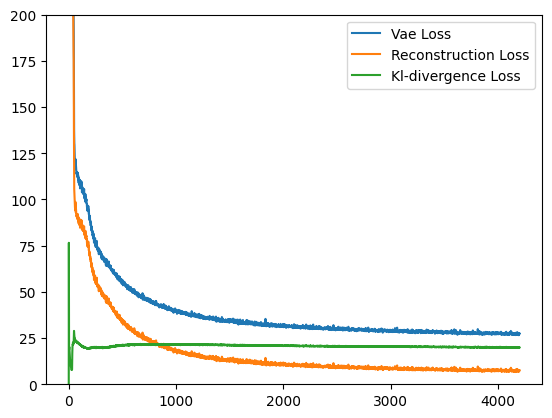

Step 88000: Vae loss: 27.110153619289438, Reconstruction loss: 7.196565876841534, Kl-divergence loss: 19.913587735652946


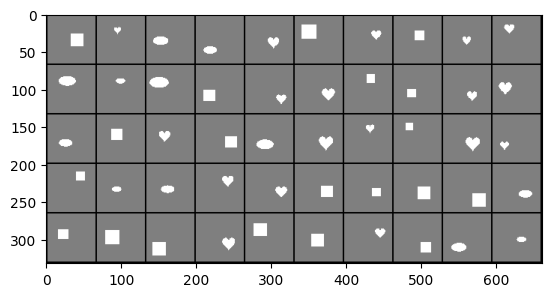

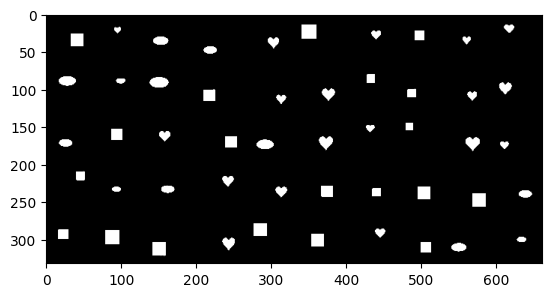

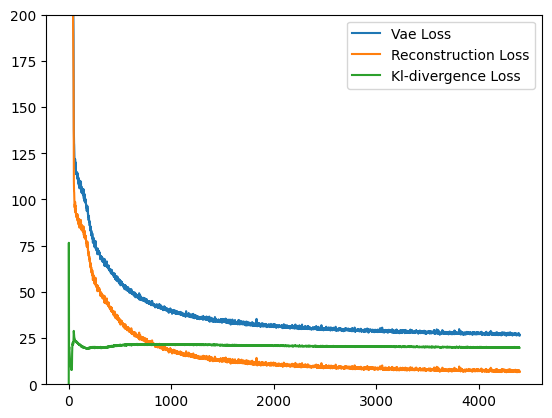

Step 92000: Vae loss: 26.924511602878642, Reconstruction loss: 7.075281928896904, Kl-divergence loss: 19.84922967720036


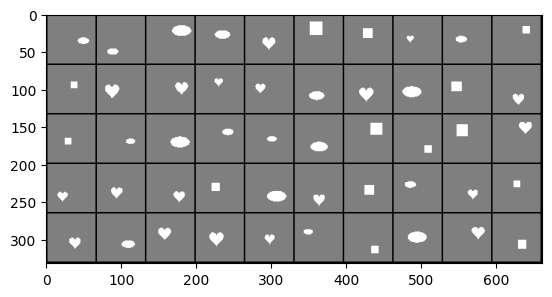

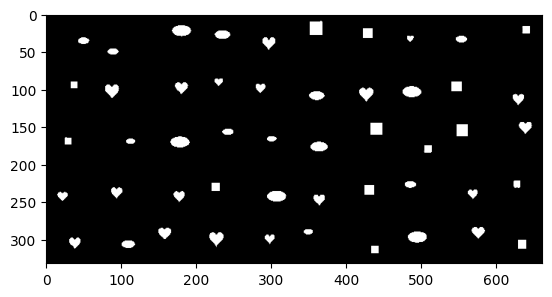

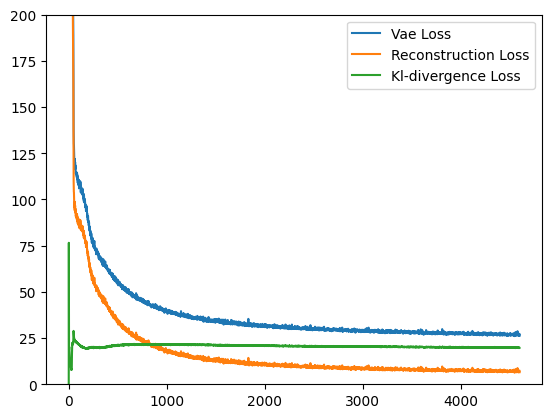

Step 96000: Vae loss: 26.700573974132524, Reconstruction loss: 6.923912034630791, Kl-divergence loss: 19.776661943435684


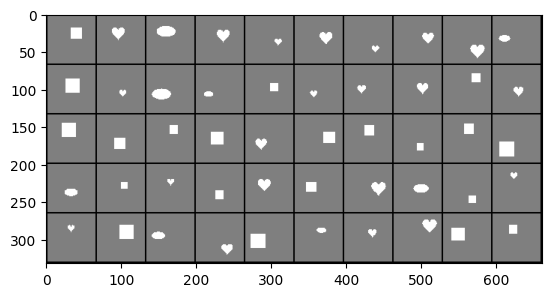

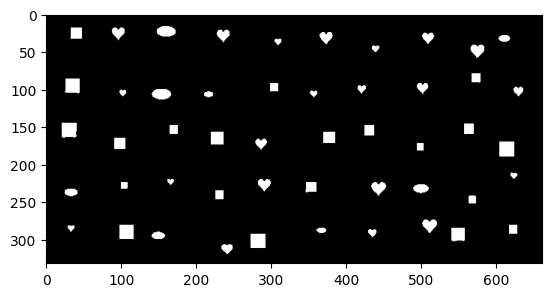

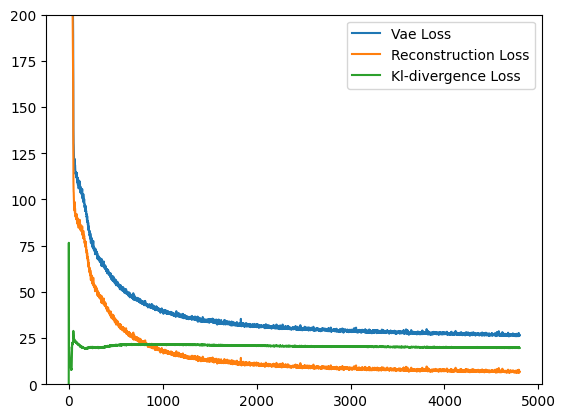

Step 100000: Vae loss: 26.51231212854385, Reconstruction loss: 6.77942555177211, Kl-divergence loss: 19.73288656759262


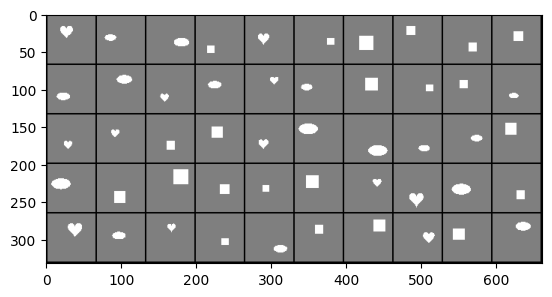

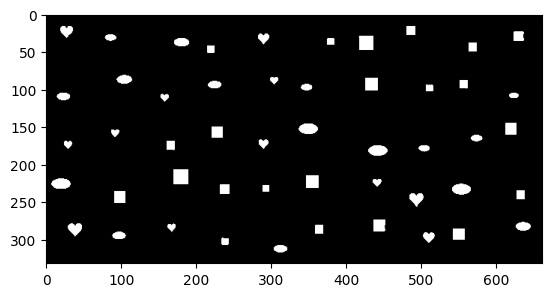

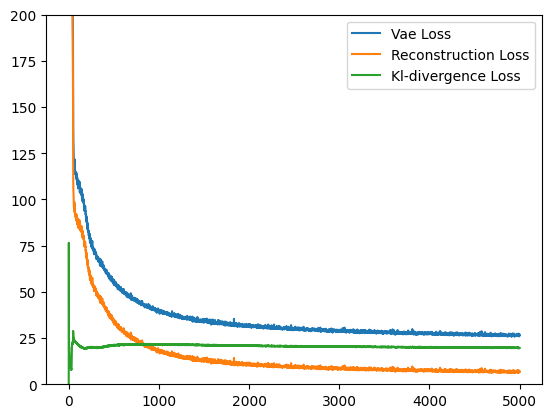

Step 104000: Vae loss: 26.361495852470426, Reconstruction loss: 6.6893114002942955, Kl-divergence loss: 19.672184450149484


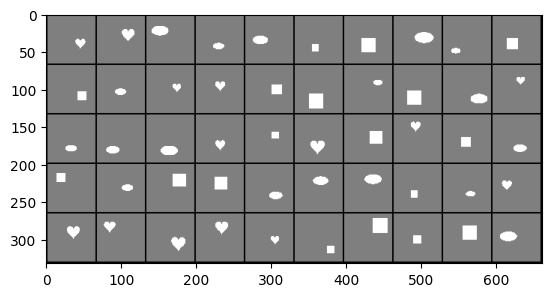

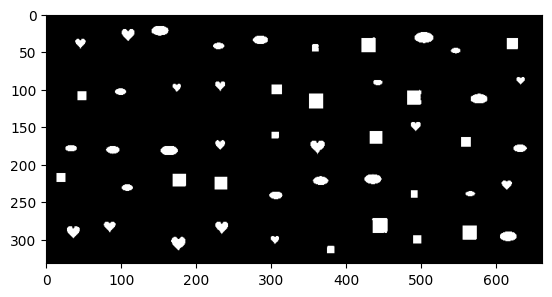

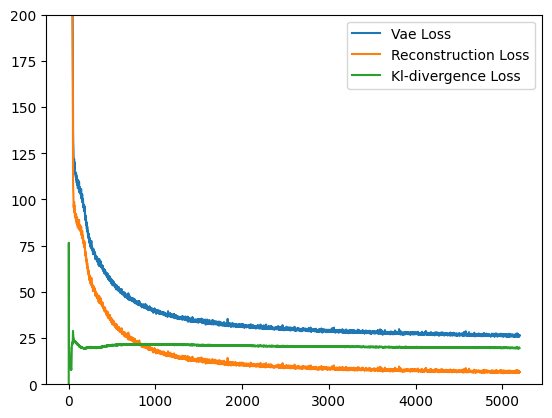

Step 108000: Vae loss: 26.208424470424628, Reconstruction loss: 6.581596895456325, Kl-divergence loss: 19.626827552318556


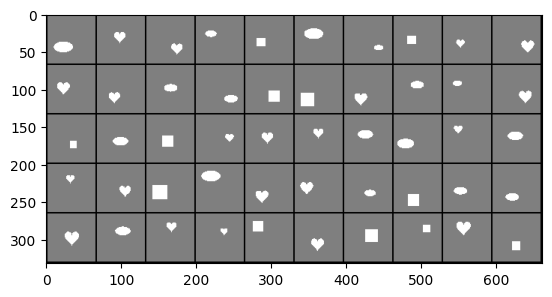

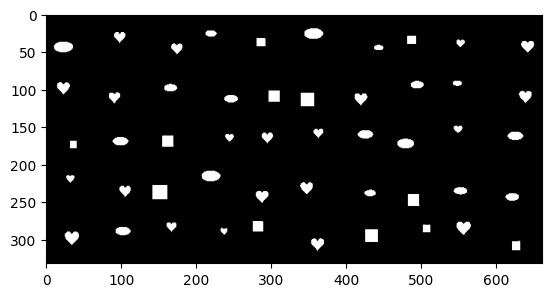

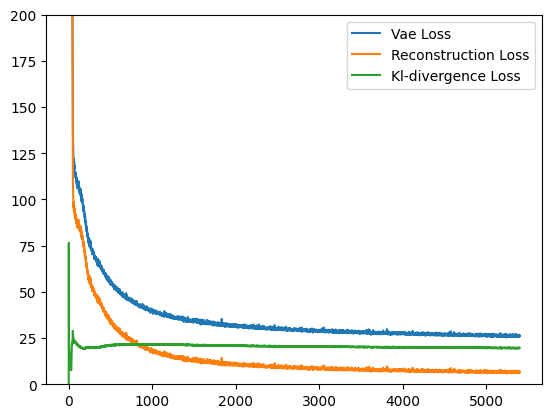

Step 112000: Vae loss: 26.020522184371902, Reconstruction loss: 6.455606875538823, Kl-divergence loss: 19.56491531085969


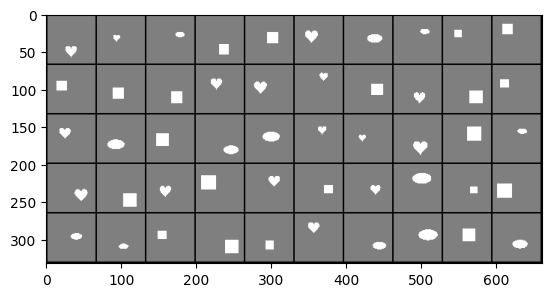

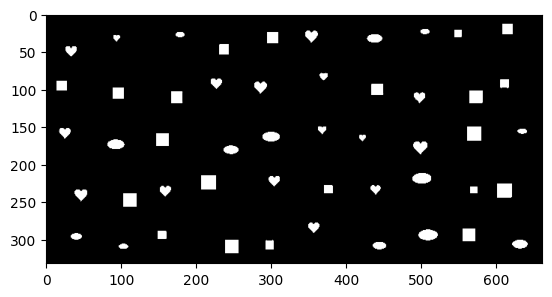

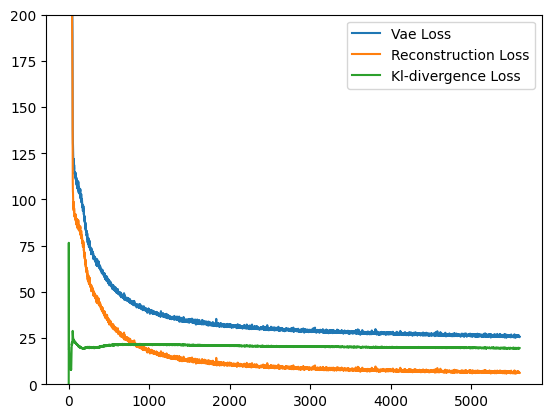

Step 116000: Vae loss: 25.8946107645034, Reconstruction loss: 6.3609323577284895, Kl-divergence loss: 19.533678396224975


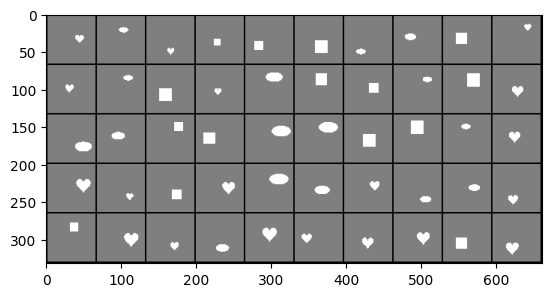

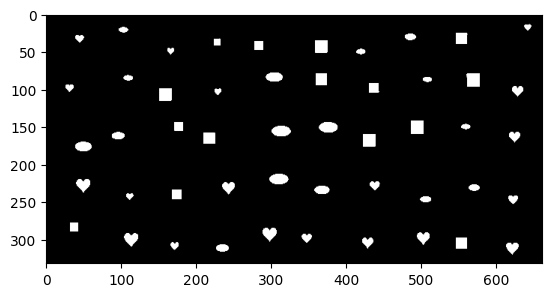

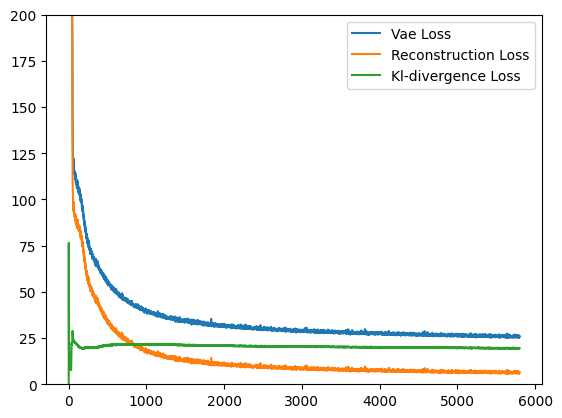

Step 120000: Vae loss: 25.737172793865216, Reconstruction loss: 6.250835088849087, Kl-divergence loss: 19.486337706565877


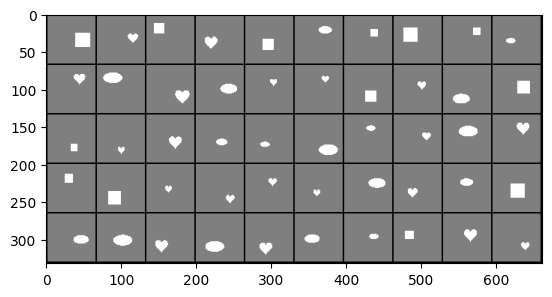

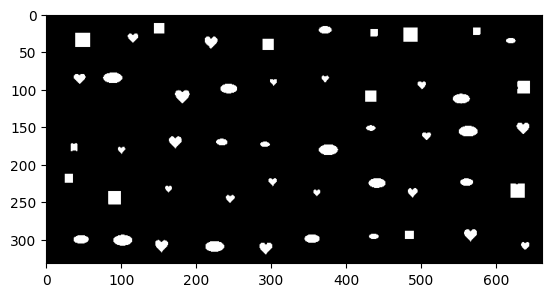

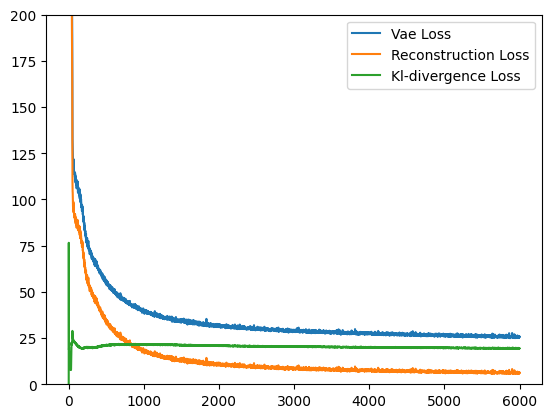

Step 124000: Vae loss: 25.592033622264875, Reconstruction loss: 6.16248354059458, Kl-divergence loss: 19.4295500802994


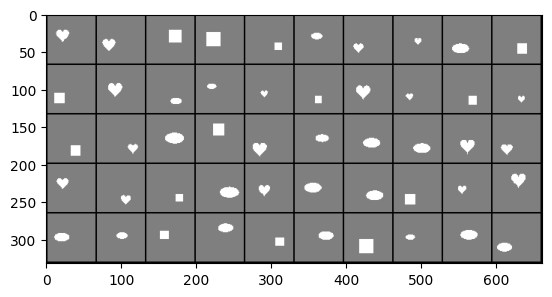

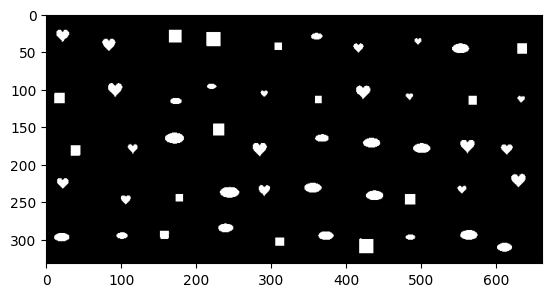

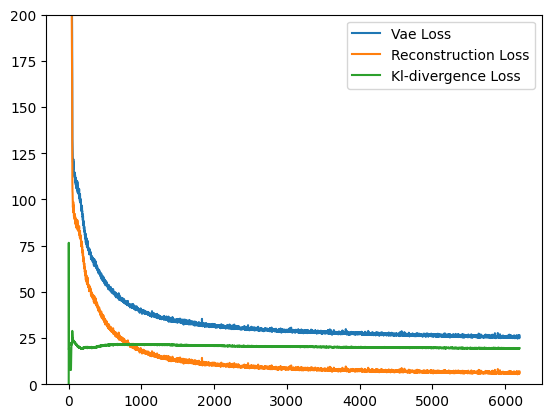

Step 128000: Vae loss: 25.478259318351682, Reconstruction loss: 6.0795352962017, Kl-divergence loss: 19.39872403240214


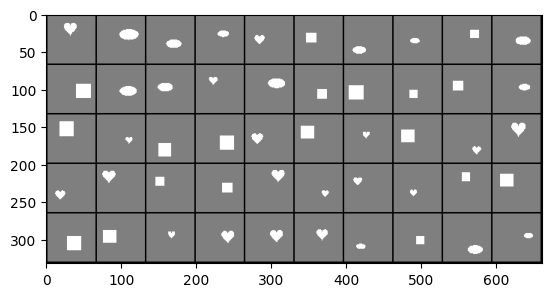

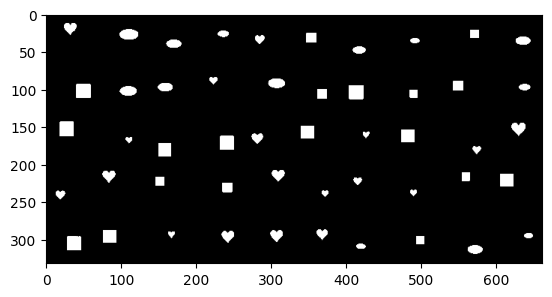

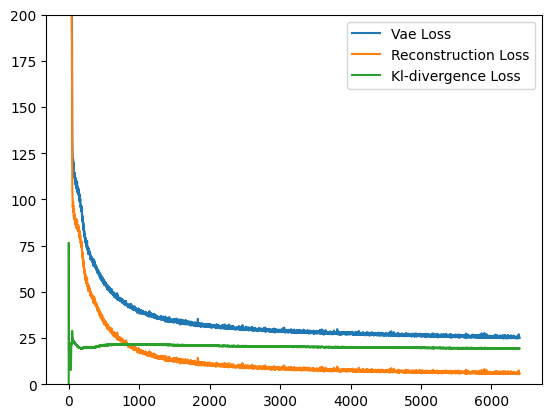

Step 132000: Vae loss: 25.32646759700773, Reconstruction loss: 5.954805152416224, Kl-divergence loss: 19.371662452220914


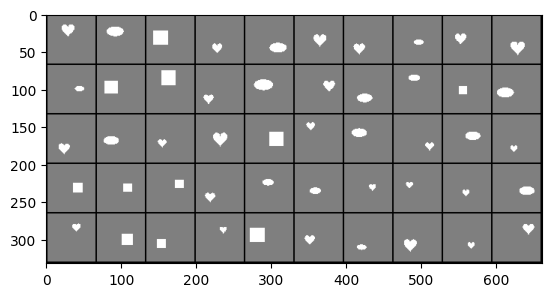

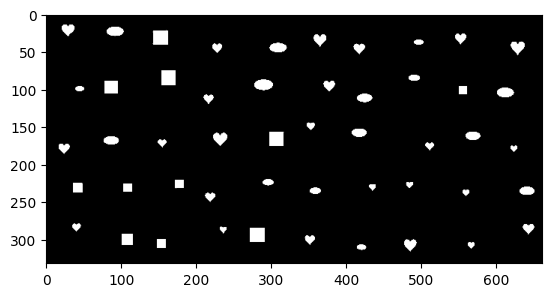

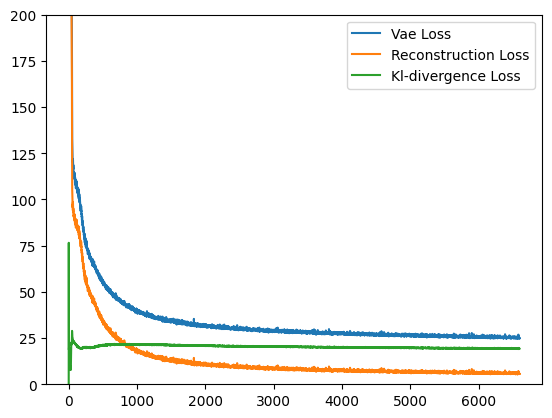

Step 136000: Vae loss: 25.23194030046465, Reconstruction loss: 5.894465967416766, Kl-divergence loss: 19.33747434616089


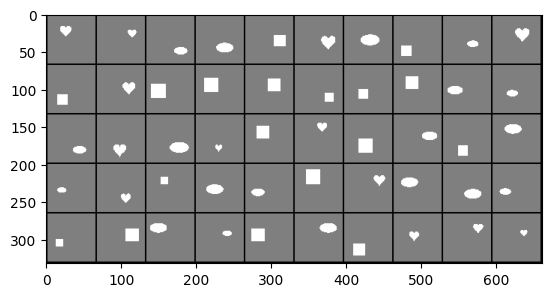

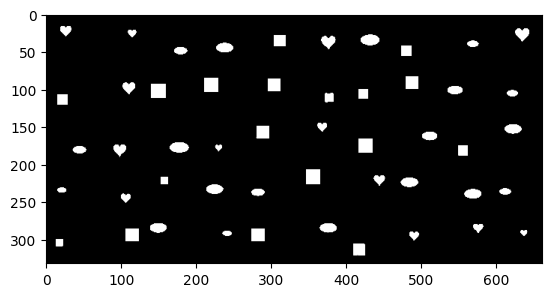

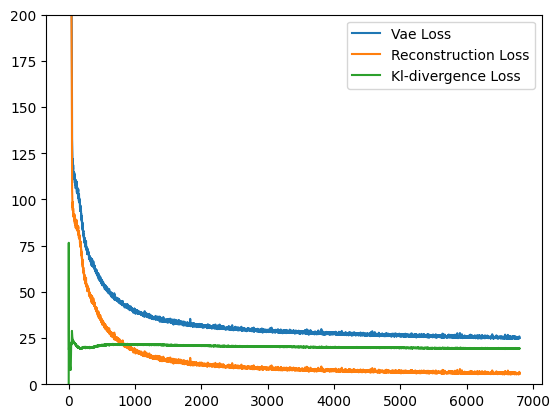

Step 140000: Vae loss: 25.12361760807037, Reconstruction loss: 5.817603784680356, Kl-divergence loss: 19.306013831138618


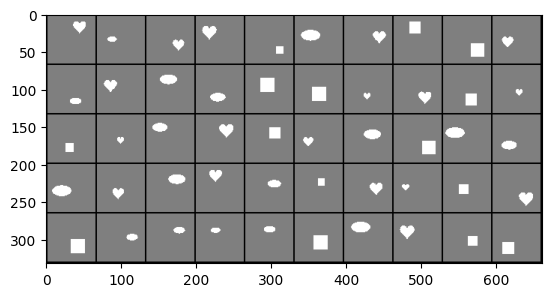

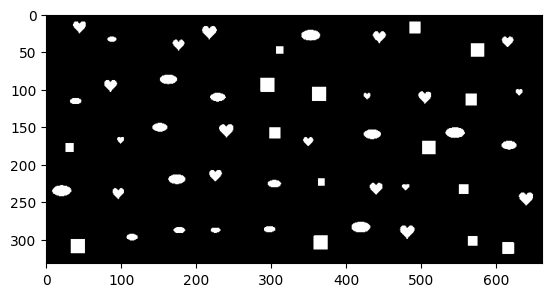

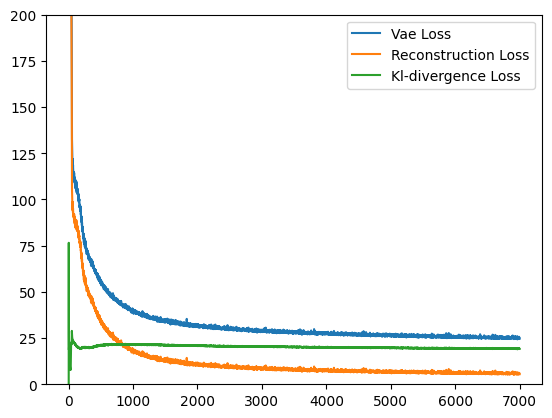

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm import tqdm



def train_vae(data_loader, vae, optimizer, reconstruction_loss, device, display_step, num_epochs):
    vae_losses = []
    recon_losses = []
    kld_losses = []

    mean_vae_loss = 0
    mean_recon_loss = 0
    mean_kld_loss = 0
    cur_step = 0

    for epoch in tqdm(range(num_epochs)):
        for batch_data in data_loader:
            x = batch_data.to(device)
            x_hat, mu, logvar = vae(x)

            # Reconstruction Loss
            recon_loss = reconstruction_loss(x_hat, x).div(batch_size)

            # KL Divergence Loss
            klds = -0.5*(1 + logvar - mu.pow(2) - logvar.exp())
            kld_loss = klds.sum(1).mean(0, True)[0]

            # Total Loss
            total_loss = recon_loss + kld_loss

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            # Logging Losses
            vae_losses += [total_loss.item()]
            recon_losses += [recon_loss.item()]
            kld_losses += [kld_loss.item()]
            mean_vae_loss += total_loss.item() / display_step
            mean_recon_loss += recon_loss.item() / display_step
            mean_kld_loss += kld_loss.item() / display_step

            if cur_step % display_step == 0 and cur_step > 0:
                display_results(x, x_hat)
                plot_losses(vae_losses, recon_losses, kld_losses)

                mean_vae_loss = 0
                mean_recon_loss = 0
                mean_kld_loss = 0

                save_checkpoint(epoch, vae, optimizer, vae_losses, recon_losses, kld_losses)

            cur_step += 1

def display_results(x, x_hat):
    image_tensor = (x + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:50], nrow=10)

    plt.figure(figsize=(10, 10))
    plt.imshow(image_grid.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()

    image_tensor_hat = (x_hat + 1) / 2
    image_unflat_hat = image_tensor_hat.detach().cpu()
    image_grid_hat = make_grid(image_unflat_hat[:50], nrow=10)

    plt.figure(figsize=(10, 10))
    plt.imshow(image_grid_hat.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()

def plot_losses(vae_losses, recon_losses, kld_losses):
    step_bins = 20
    num_examples = (len(vae_losses) // step_bins) * step_bins
    plt.plot(
        range(num_examples // step_bins),
        torch.Tensor(vae_losses[:num_examples]).view(-1, step_bins).mean(1),
        label="Vae Loss"
    )
    plt.plot(
        range(num_examples // step_bins),
        torch.Tensor(recon_losses[:num_examples]).view(-1, step_bins).mean(1),
        label="Reconstruction Loss"
    )
    plt.plot(
        range(num_examples // step_bins),
        torch.Tensor(kld_losses[:num_examples]).view(-1, step_bins).mean(1),
        label="Kl-divergence Loss"
    )
    plt.ylim(0, 200)
    plt.legend()
    plt.show()

def save_checkpoint(epoch, vae, optimizer, vae_losses, recon_losses, kld_losses):
    torch.save({
        'epoch': epoch,
        'model_state_dict': vae.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'vae_losses': vae_losses,
        'recon_losses': recon_losses,
        'kld_losses': kld_losses,
    }, save_path)

train_vae(data_loader, VAE().to(device), optim.Adam(VAE().to(device).parameters(), lr=0.0001),
          nn.BCEWithLogitsLoss(size_average=False), device, display_step, num_epochs)


In [8]:
num_samples = 5000
base_path = "/content/dataset/vae/"
real_images = custom_dataset.get_items(num_samples)
real_images = torch.Tensor.view(real_images, (-1, 1, 64, 64))

generated_images = vae.generate(num_samples, batch_size, device)
reconstructed_images = vae.reconstruct(data_loader, num_samples, batch_size, device)
os.makedirs("real", exist_ok=True)

for i in range(real_images.size(0)):
    save_image(real_images[i, :, :, :], os.path.join("real", f'image_{i}.png'), format='png')

os.makedirs("gen", exist_ok=True)
for i in range(generated_images.size(0)):
    save_image(generated_images[i, :, :, :], os.path.join("gen", f'image_{i}.png'), format='png')



os.makedirs("recon", exist_ok=True)
for i in range(reconstructed_images.size(0)):
    save_image(reconstructed_images[i, :, :, :], os.path.join("recon", f'image_{i}.png'), format='png')


Generated images saved in /content/dataset/vae/real in a lossless format.
Generated images saved in /content/dataset/vae/gen in a lossless format.
Generated images saved in /content/dataset/vae/recon in a lossless format.


In [9]:
!python -m pytorch_fid /content/dataset/vae/gen /content/dataset/vae/real
!python -m pytorch_fid /content/dataset/vae/real /content/dataset/vae/recon

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:00<00:00, 239MB/s]
100% 100/100 [00:19<00:00,  5.03it/s]
100% 100/100 [00:19<00:00,  5.09it/s]
FID:  30.508212753648607
100% 100/100 [00:19<00:00,  5.08it/s]
100% 100/100 [00:19<00:00,  5.07it/s]
FID:  28.37715372519159
100% 100/100 [00:19<00:00,  5.10it/s]
100% 100/100 [00:19<00:00,  5.07it/s]
FID:  2.029129425872867


In [11]:
from math import exp

class PIDControl:
    def __init__(self):
        self.I_k1 = 0.0
        self.W_k1 = 1.0
        self.e_k1 = 0.0

    def _Kp_fun(self, Err, scale=1):
        return 1.0 / (1.0 + float(scale) * exp(Err))

    def update_integral(self, error_k, Ki):
        return self.I_k1 + Ki * error_k if self.W_k1 >= 1 else self.I_k1

    def update_weight(self, Pk, Ik):
        return Pk + Ik if self.W_k1 >= 1 else 1

    def cap_weight(self, Wk):
        return max(Wk, 1)

    def pid(self, exp_KL, kl_divergence, Kp=0.01, Ki=0.001, Kd=0.01):
        error_k = exp_KL - kl_divergence

        Pk = Kp * self._Kp_fun(error_k) + 1
        Ik = self.update_integral(error_k, Ki)

        Wk = self.update_weight(Pk, Ik)
        self.W_k1 = self.cap_weight(Wk)
        self.I_k1 = Ik

        return self.W_k1, error_k


In [11]:
control_vae_kl8 = VAE().to(device)
optimizer = optim.Adam(control_vae_kl8.parameters(), lr=0.0001)
reconstruction_loss = nn.BCEWithLogitsLoss(size_average=False)
torch.autograd.set_detect_anomaly(False)
exp_kl_max = 8
kp, ki = 0.01, 0.001
iterations = 10

PID = PIDControl()

load_pth = False
cur_step = 0
mean_vae_loss = 0
mean_recon_loss = 0
mean_kld_loss = 0
mean_beta = 0
display_step = 20000
period = 3000
step_value = 0.15
num_epochs = 500
recon_losses_kl8 = []
vae_losses = []
kld_losses_kl8 = []
beta_vals = []
beta = 0
cur_exp_kl = 0.5


  0%|          | 0/500 [00:00<?, ?it/s]

0.65
Step 0: Vae loss: 0.13335257568359374, Reconstruction loss: 0.1333520263671875, Kl-divergence loss: 5.446487106382847e-07, Beta loss: 5.014076886137065e-05


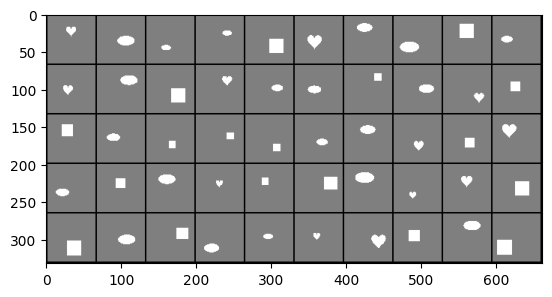

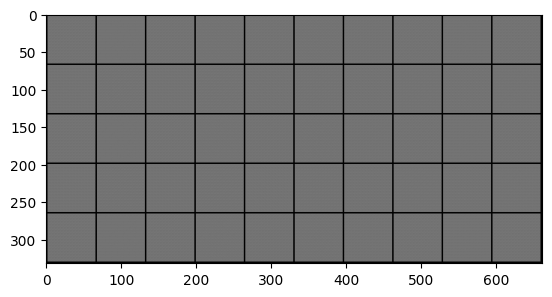

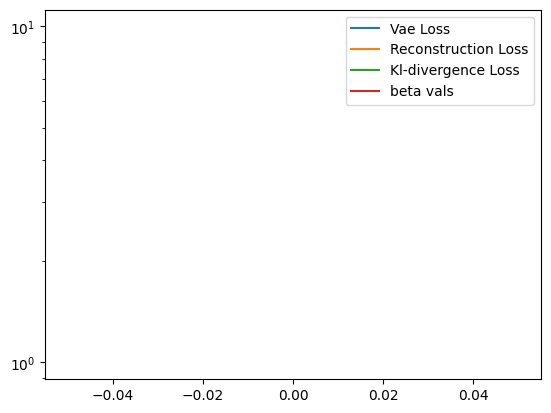

1.5499999999999998
Step 20000: Vae loss: 368.24877184524433, Reconstruction loss: 212.6689928882596, Kl-divergence loss: 4.271511984408466, Beta loss: 42.19232240875073


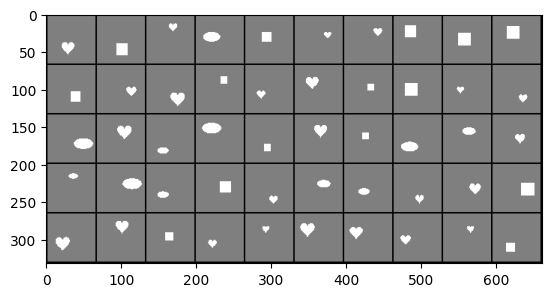

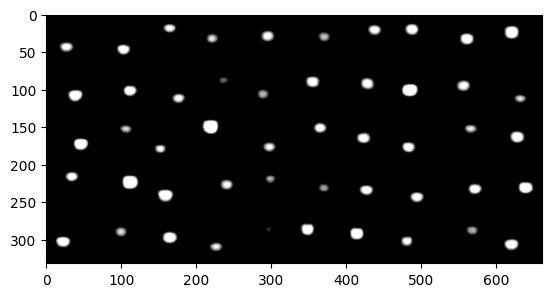

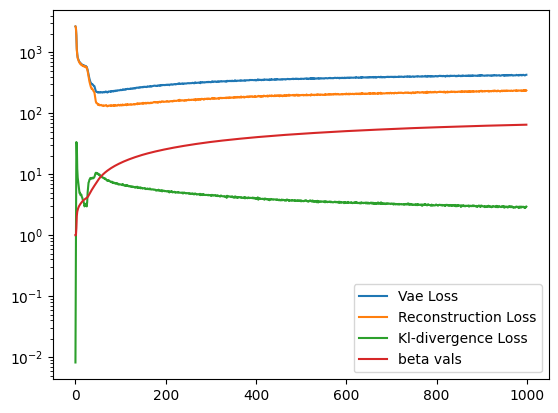

2.599999999999999
Step 40000: Vae loss: 442.08994650879083, Reconstruction loss: 255.095335184479, Kl-divergence loss: 2.5892117204427785, Beta loss: 72.357850088003


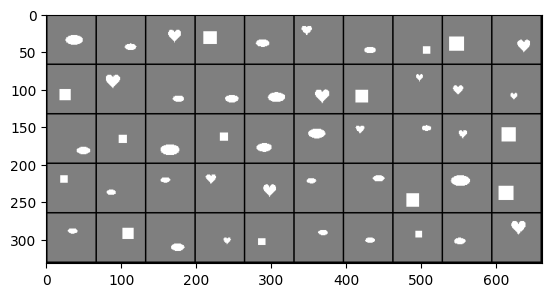

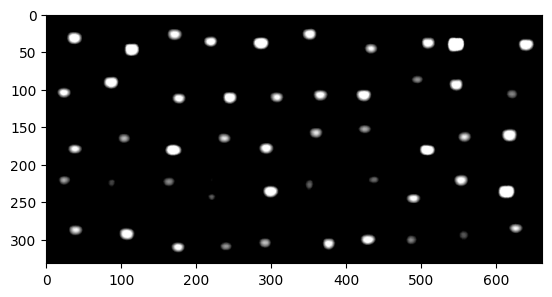

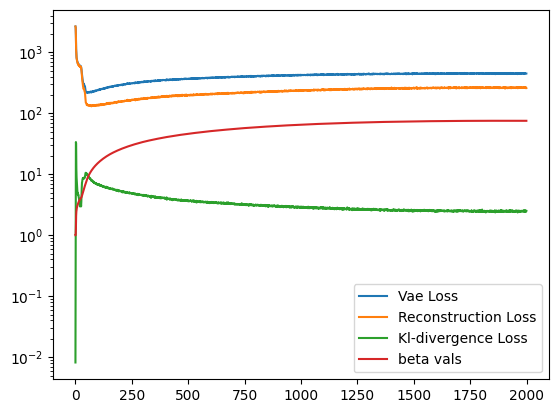

3.6499999999999986
Step 60000: Vae loss: 439.12945947112996, Reconstruction loss: 251.23665531692367, Kl-divergence loss: 2.6242960789918857, Beta loss: 71.71339841494093


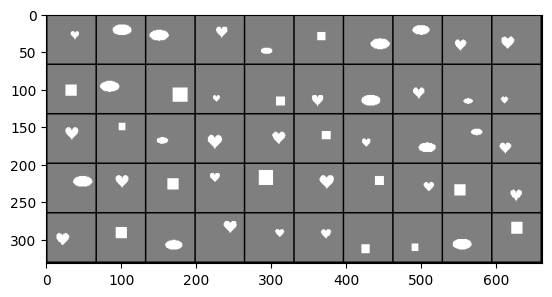

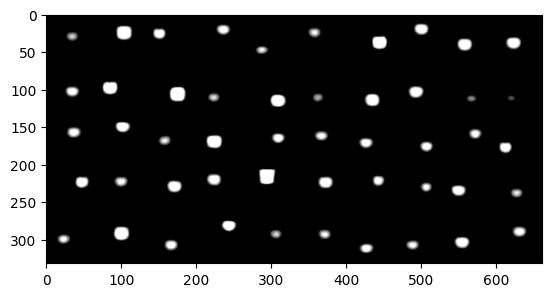

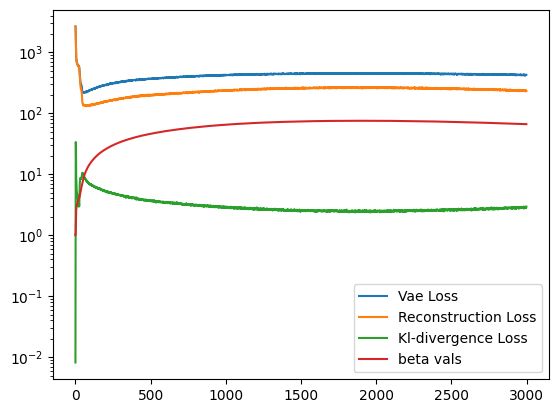

4.55
Step 80000: Vae loss: 397.38483634643444, Reconstruction loss: 210.30284265670787, Kl-divergence loss: 3.2397197646975324, Beta loss: 58.10691631892485


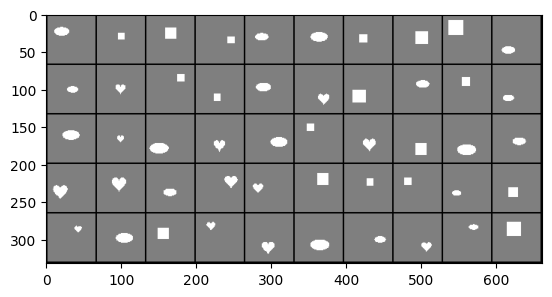

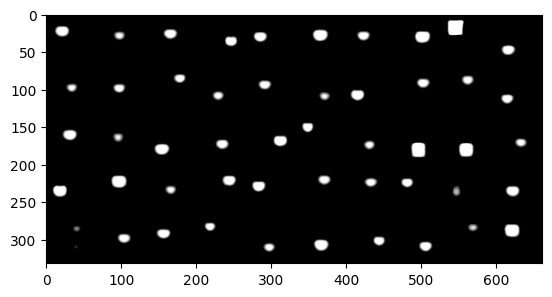

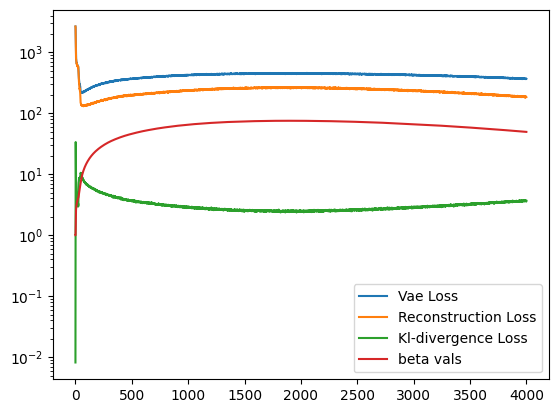

5.600000000000002
Step 100000: Vae loss: 331.10143811797985, Reconstruction loss: 159.903840470124, Kl-divergence loss: 4.23312465354205, Beta loss: 40.82169844139666


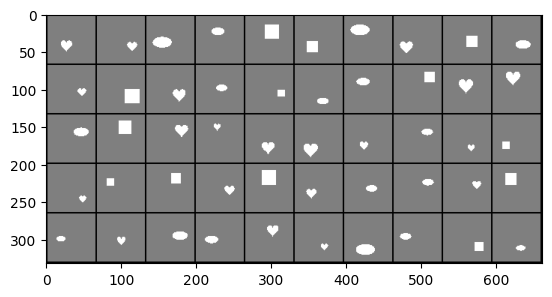

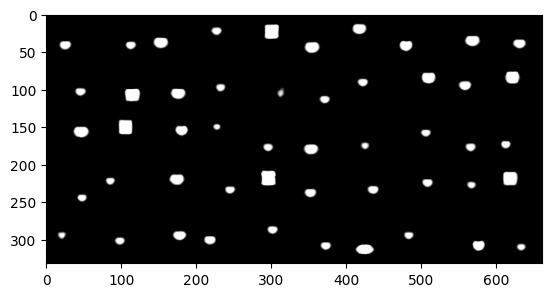

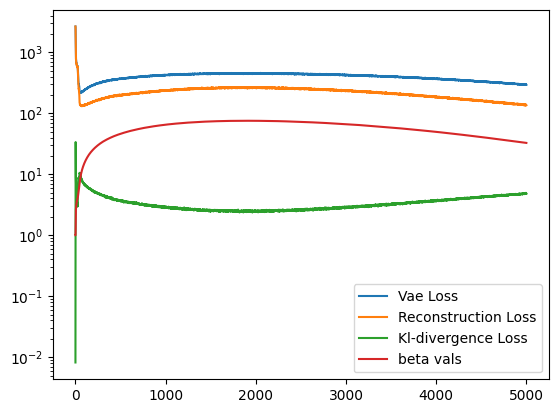

6.650000000000005
Step 120000: Vae loss: 257.2471865486157, Reconstruction loss: 116.58712076225271, Kl-divergence loss: 5.4603932921170895, Beta loss: 26.00275876323163


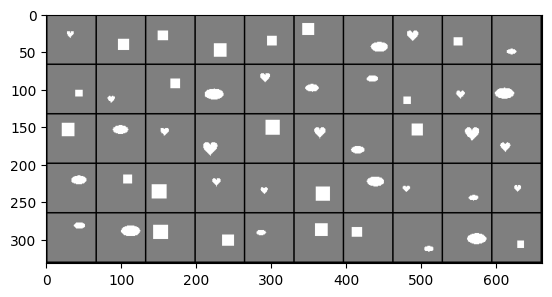

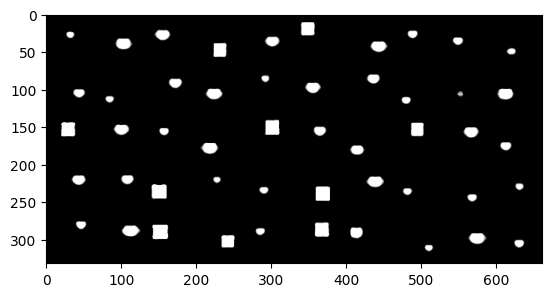

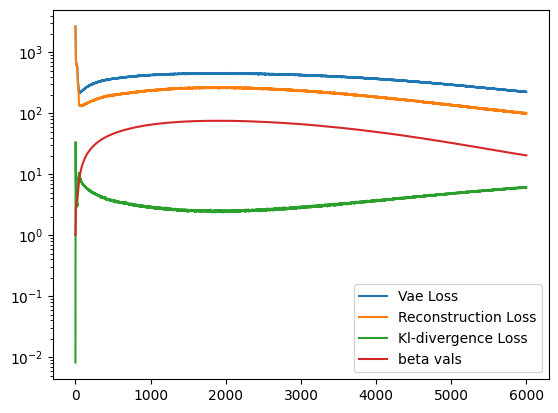

7.550000000000007
Step 140000: Vae loss: 198.37738116836584, Reconstruction loss: 84.69361684684795, Kl-divergence loss: 6.763510335493082, Beta loss: 16.896966264612335


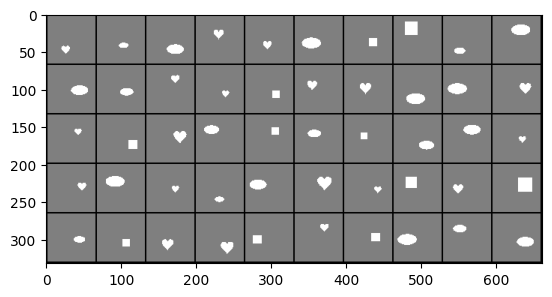

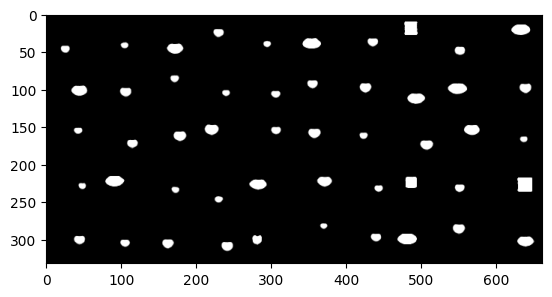

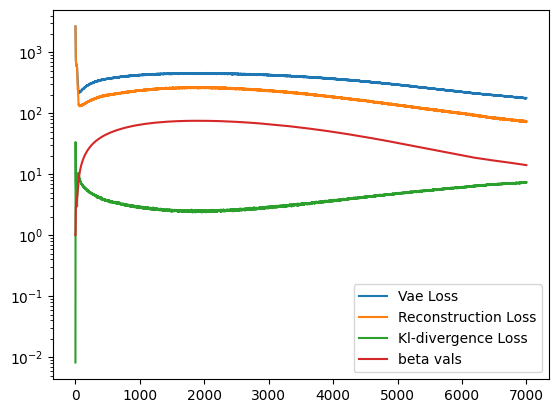

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_VAE(control_vae, optimizer, reconstruction_loss, data_loader, device, exp_kl_max, step_value, period, PID, display_step, num_epochs, save_path):
    # Initialize variables
    cur_exp_kl = 0.5
    mean_vae_loss = 0
    mean_recon_loss = 0
    mean_kld_loss = 0
    mean_beta = 0
    recon_losses = []
    vae_losses = []
    kld_losses = []
    beta_vals = []
    beta = 0
    cur_step = 0

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for batch_data in data_loader:
            x = batch_data.to(device)
            x_hat, mu, logvar = control_vae(x)

            recon_loss = reconstruction_loss(x_hat, x).div(len(x))
            klds = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
            kld_loss = klds.sum(1).mean(0, True)[0]

            if cur_step % period == 0:
                cur_exp_kl += step_value
            if cur_exp_kl > exp_kl_max:
                cur_exp_kl = exp_kl_max

            beta, _ = PID.pid(cur_exp_kl, kld_loss.item(), Kp=0.01, Ki=-0.001, Kd=0.01)

            total_loss = recon_loss + beta * kld_loss
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            # Record losses and beta values
            vae_losses.append(total_loss.item())
            recon_losses.append(recon_loss.item())
            kld_losses.append(kld_loss.item())
            beta_vals.append(beta)

            # Update mean losses and beta
            mean_vae_loss += total_loss.item() / display_step
            mean_recon_loss += recon_loss.item() / display_step
            mean_kld_loss += kld_loss.item() / display_step
            mean_beta += beta / display_step

            # Print and visualize statistics
            if cur_step % display_step == 0:
                print(cur_exp_kl)
                print(f"Step {cur_step}: VAE loss: {mean_vae_loss}, Reconstruction loss: {mean_recon_loss}, Kl-divergence loss: {mean_kld_loss}, Beta loss: {mean_beta}")

                # Visualize images
                visualize_images(x, x_hat)

                # Plot loss curves
                plot_loss_curves(vae_losses, recon_losses, kld_losses, beta_vals)

                # Reset mean losses
                mean_vae_loss = 0
                mean_recon_loss = 0
                mean_kld_loss = 0
                mean_beta = 0

                # Save checkpoint
                save_checkpoint(control_vae, optimizer, vae_losses, recon_losses, kld_losses, beta_vals, mean_vae_loss, mean_recon_loss, mean_kld_loss, mean_beta, cur_step, cur_exp_kl, save_path)

            cur_step += 1

def visualize_images(x, x_hat):
    # Visualize images
    image_tensor = (x + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:50], nrow=10)

    plt.figure(figsize=(10, 10))
    plt.imshow(image_grid.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()

    image_tensor_hat = (x_hat + 1) / 2
    image_unflat_hat = image_tensor_hat.detach().cpu()
    image_grid_hat = make_grid(image_unflat_hat[:50], nrow=10)

    plt.figure(figsize=(10, 10))
    plt.imshow(image_grid_hat.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()

def plot_loss_curves(vae_losses, recon_losses, kld_losses, beta_vals):
    # Plot loss curves
    step_bins = 20
    num_examples = (len(vae_losses) // step_bins) * step_bins
    plt.plot(
        range(num_examples // step_bins),
        torch.Tensor(vae_losses[:num_examples]).view(-1, step_bins).mean(1),
        label="Vae Loss"
    )
    plt.plot(
        range(num_examples // step_bins),
        torch.Tensor(recon_losses[:num_examples]).view(-1, step_bins).mean(1),
        label="Reconstruction Loss"
    )
    plt.plot(
        range(num_examples // step_bins),
        torch.Tensor(kld_losses[:num_examples]).view(-1, step_bins).mean(1),
        label="Kl-divergence Loss"
    )
    plt.plot(
        range(num_examples // step_bins),
        torch.Tensor(beta_vals[:num_examples]).view(-1, step_bins).mean(1),
        label="beta vals"
    )
    plt.yscale("log")
    plt.legend()
    plt.show()

train_VAE(control_vae_kl8, optimizer, reconstruction_loss, data_loader, device, exp_kl_max=8, step_value=0.15, period=3000, PID=PIDControl(), display_step=20000, num_epochs=500)


In [14]:
!python -m pytorch_fid /content/dataset/ControlVAE_KL8/gen /content/dataset/ControlVAE_KL8/real
!python -m pytorch_fid /content/dataset/ControlVAE_KL8/gen /content/dataset/ControlVAE_KL8/recon

100% 100/100 [00:19<00:00,  5.08it/s]
100% 100/100 [00:19<00:00,  5.11it/s]
FID:  94.58279816333302
100% 100/100 [00:19<00:00,  5.14it/s]
100% 100/100 [00:19<00:00,  5.04it/s]
FID:  99.48426873762105
100% 100/100 [00:19<00:00,  5.11it/s]
100% 100/100 [00:19<00:00,  5.09it/s]
FID:  1.7815603021957003


### ControlVAE KL14

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from tqdm import tqdm

display_step = 20000
period = 3000
step_value = 0.15
num_epochs = 500
exp_kl_max = 1.0

recon_losses_kl14 = []
vae_losses = []
kld_losses_kl14 = []
beta_vals = []

cur_step = 0
cur_exp_kl = 0.5
mean_vae_loss, mean_recon_loss, mean_kld_loss, mean_beta = 0, 0, 0, 0

for epoch in tqdm(range(num_epochs)):
    for batch_data in data_loader:
        x = batch_data.to(device)
        x_hat, mu, logvar = control_vae_kl14(x)

        recon_loss = reconstruction_loss(x_hat, x).div(batch_size)
        klds = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
        kld_loss = klds.sum(1).mean(0, True)[0]

        if cur_step % period == 0:
            cur_exp_kl += step_value
        if cur_exp_kl > exp_kl_max:
            cur_exp_kl = exp_kl_max

        beta, _ = PID.pid(cur_exp_kl, kld_loss.item(), Kp=0.01, Ki=-0.001, Kd=0.01)

        total_loss = recon_loss + beta * kld_loss
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if cur_step % display_step == 0 and cur_step > 0:
                print(cur_exp_kl)
                print(f"Step {cur_step}: VAE loss: {mean_vae_loss}, Reconstruction loss: {mean_recon_loss}, Kl-divergence loss: {mean_kld_loss}, Beta loss: {mean_beta}")

                # Visualize images
                visualize_images(x, x_hat)

                # Plot loss curves
                plot_loss_curves(vae_losses, recon_losses, kld_losses, beta_vals)

                # Reset mean losses
                mean_vae_loss = 0
                mean_recon_loss = 0
                mean_kld_loss = 0
                mean_beta = 0

                save_checkpoint(control_vae, optimizer, vae_losses, recon_losses, kld_losses, beta_vals, mean_vae_loss, mean_recon_loss, mean_kld_loss, mean_beta, cur_step, cur_exp_kl, save_path)

            cur_step += 1
        vae_losses.append(total_loss.item())
        recon_losses_kl14.append(recon_loss.item())
        kld_losses_kl14.append(kld_loss.item())
        beta_vals.append(beta)
        mean_vae_loss += total_loss.item() / display_step
        mean_recon_loss += recon_loss.item() / display_step
        mean_kld_loss += kld_loss.item() / display_step
        mean_beta += beta / display_step

        cur_step += 1


  0%|          | 0/500 [00:00<?, ?it/s]

1.5499999999999998
Step 20000: Vae loss: 361.73940202188487, Reconstruction loss: 187.08819190332946, Kl-divergence loss: 4.467062692475332, Beta loss: 48.02360816352312


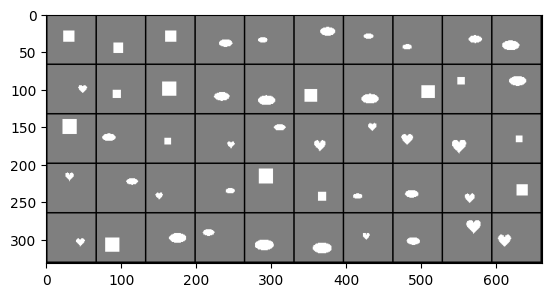

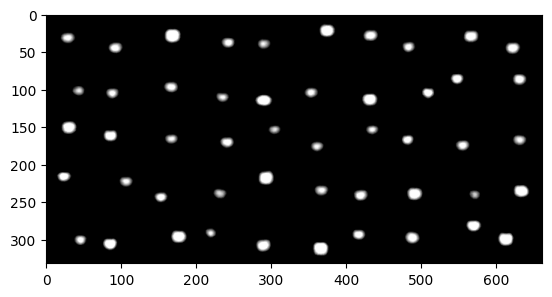

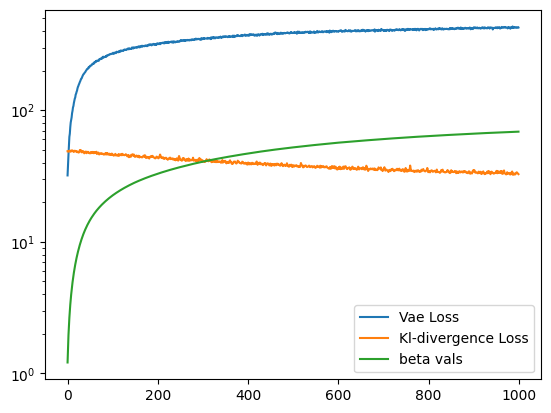

2.599999999999999
Step 40000: Vae loss: 439.8064616241462, Reconstruction loss: 260.82637759780835, Kl-divergence loss: 2.410464098256844, Beta loss: 74.33366962847906


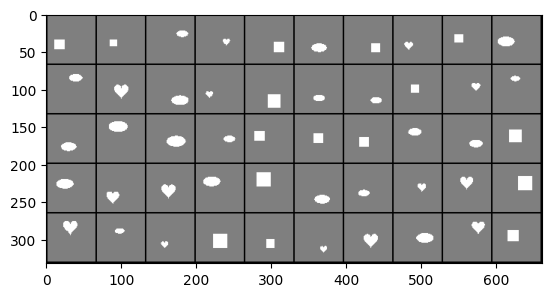

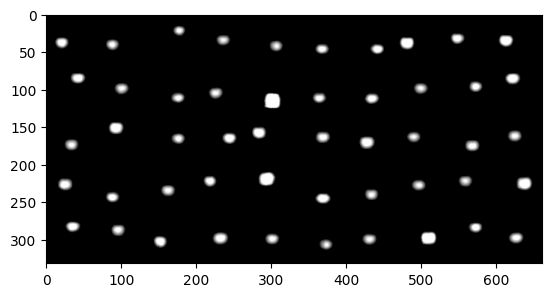

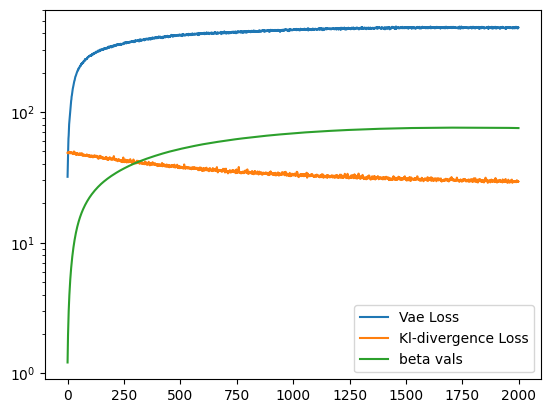

3.6499999999999986
Step 60000: Vae loss: 429.5871975799539, Reconstruction loss: 252.4685491050718, Kl-divergence loss: 2.50979306356907, Beta loss: 70.75387535926255


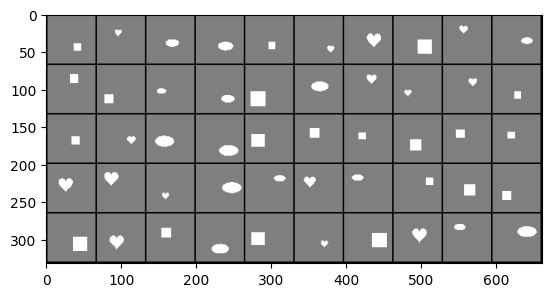

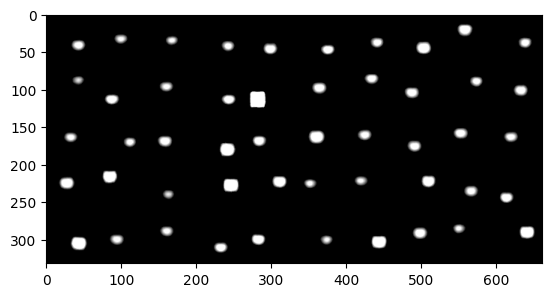

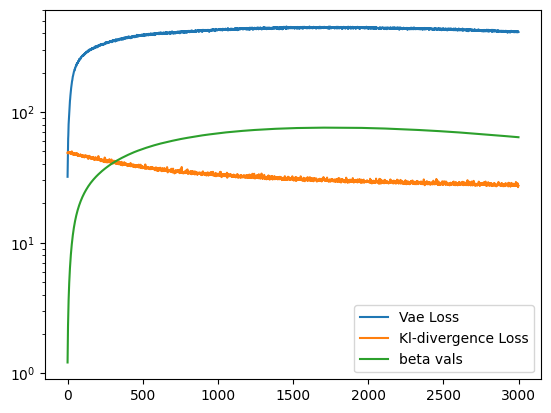

4.55
Step 80000: Vae loss: 385.39162566986, Reconstruction loss: 206.15624196472115, Kl-divergence loss: 3.229430266809454, Beta loss: 55.90141667633686


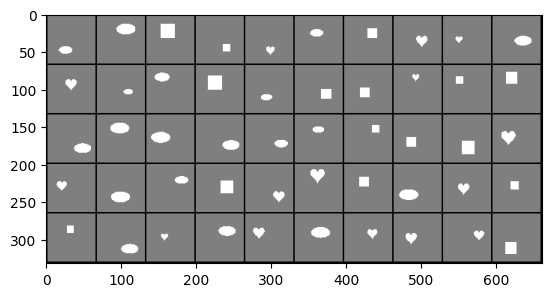

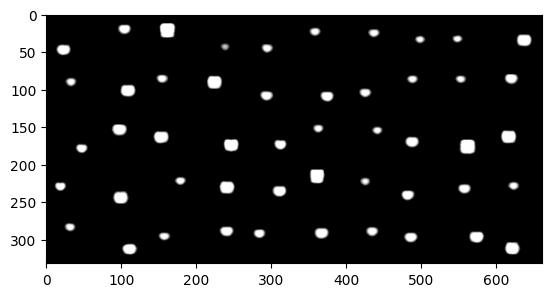

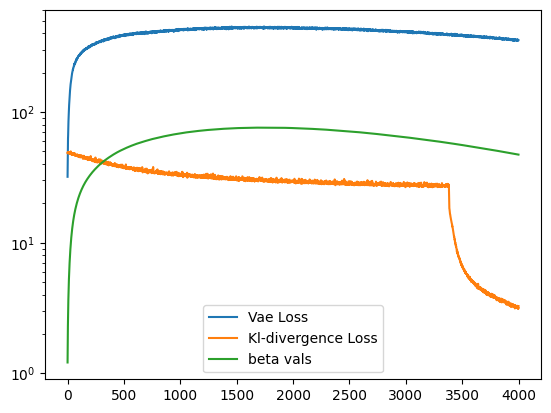

5.600000000000002
Step 100000: Vae loss: 320.7182900451651, Reconstruction loss: 155.4318893058769, Kl-divergence loss: 4.275097602117067, Beta loss: 39.02669376892047


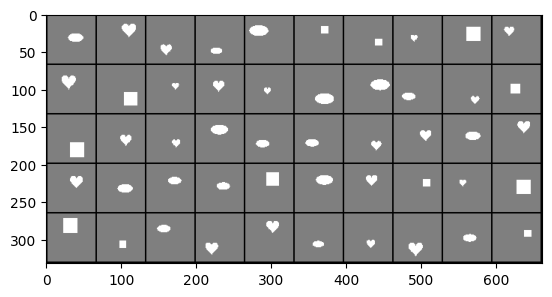

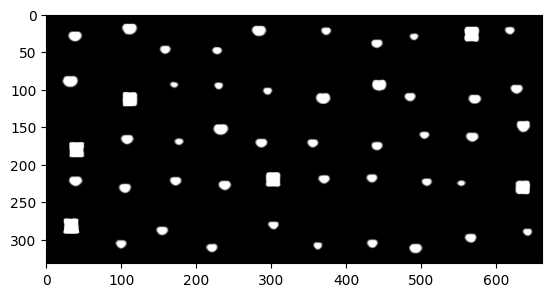

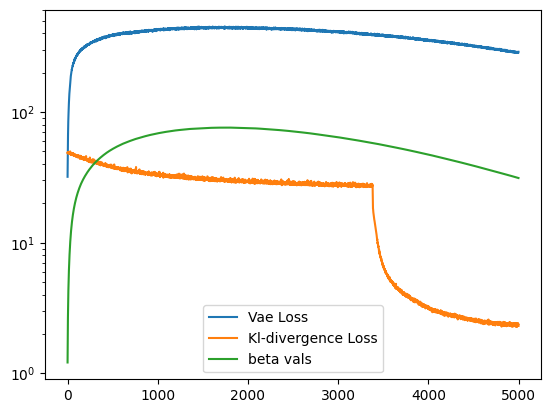

6.650000000000005
Step 120000: Vae loss: 250.47185419998124, Reconstruction loss: 114.48801219520684, Kl-divergence loss: 5.4884734274864, Beta loss: 25.001341256543014


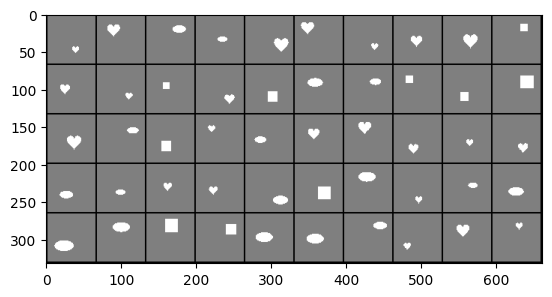

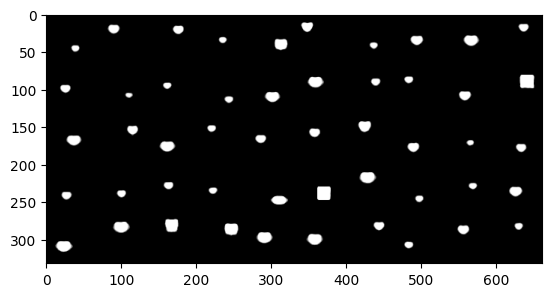

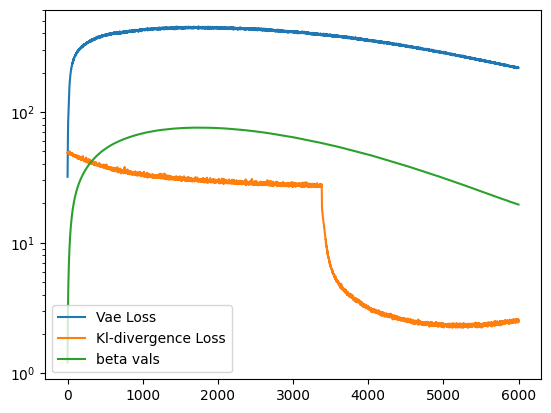

7.550000000000007
Step 140000: Vae loss: 193.81239040069585, Reconstruction loss: 83.60245985832168, Kl-divergence loss: 6.784487547516805, Beta loss: 16.326821394844387


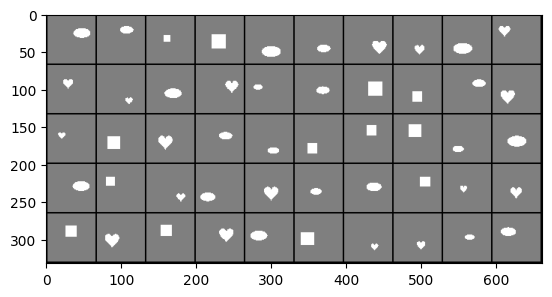

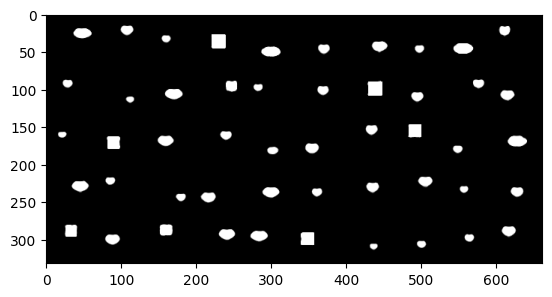

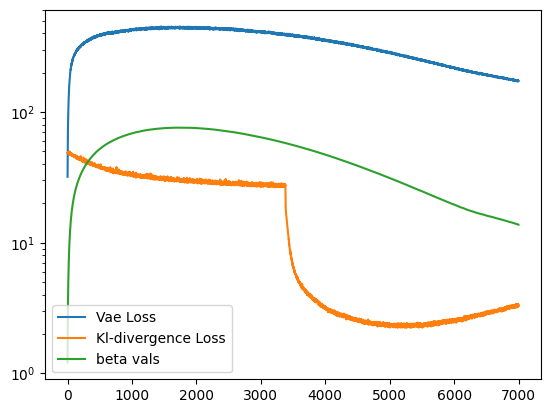

In [14]:

cur_step = 0
mean_vae_loss = 0
mean_recon_loss = 0
mean_kld_loss = 0
mean_beta = 0
display_step = 20000
period = 3000
step_value = 0.15
num_epochs = 500
recon_losses_kl8 = []
vae_losses = []
kld_losses_kl8 = []
beta_vals = []
beta = 0
cur_exp_kl = 0.5
vae_losses = []
recon_losses = []
kld_losses = []
for epoch in tqdm(range(num_epochs)):
    for batch_data in data_loader:
        x = batch_data.to(device)
        x_hat, mu, logvar = control_vae_kl14(x)

        recon_loss = reconstruction_loss(x_hat, x).div(batch_size)
        klds = -0.5*(1 + logvar - mu.pow(2) - logvar.exp())
        kld_loss = klds.sum(1).mean(0, True)[0]

        if cur_step%period==0:
            cur_exp_kl += step_value
        if cur_exp_kl > exp_kl_max:
            cur_exp_kl = exp_kl_max

        beta, _ = PID.pid(cur_exp_kl, kld_loss.item(), Kp=0.01, Ki=-0.001, Kd=0.01)


        total_loss = recon_loss + beta * kld_loss
        optimizer.zero_grad()
        total_loss.backward()

        optimizer.step()

        if cur_step % display_step == 0 and cur_step > 0:
            print(cur_exp_kl)
            print(f"Step {cur_step}: Vae loss: {mean_vae_loss}, Reconstruction loss: {mean_recon_loss}, Kl-divergence loss: {mean_kld_loss}, Beta loss: {mean_beta}")
            plt.figure(figsize=(10, 10))
            plt.imshow(image_grid.permute(1, 2, 0).squeeze(), cmap='gray')
            plt.axis('off')
            plt.show()

            image_tensor_hat = (x_hat + 1) / 2
            image_unflat_hat = image_tensor_hat.detach().cpu()
            image_grid_hat = make_grid(image_unflat_hat[:50], nrow=10)

            plt.figure(figsize=(10, 10))
            plt.imshow(image_grid_hat.permute(1, 2, 0).squeeze(), cmap='gray')
            plt.axis('off')
            plt.show()

            step_bins = 20
            num_examples = (len(vae_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(vae_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Vae Loss"
            )
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(kld_losses_kl14[:num_examples]).view(-1, step_bins).mean(1),
                label="Kl-divergence Loss"
            )
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(beta_vals[:num_examples]).view(-1, step_bins).mean(1),
                label="beta vals"
            )
            plt.yscale("log")
            plt.legend()
            plt.show()
            mean_vae_loss = 0
            mean_recon_loss = 0
            mean_kld_loss = 0
            mean_beta = 0

            torch.save({
                'epoch': epoch,
                'model_state_dict': control_vae_kl14.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'vae_losses': vae_losses,
                'recon_losses': recon_losses_kl14,
                'kld_losses': kld_losses_kl14,
                'beta_vals': beta_vals,
                'mean_vae_loss': mean_vae_loss,
                'mean_recon_loss': mean_recon_loss,
                'mean_kld_loss': mean_kld_loss,
                'mean_beta': mean_beta,
                'cur_step': cur_step,
                'cur_exp_kl': cur_exp_kl
            }, save_path)

        vae_losses += [total_loss.item()]
        recon_losses_kl14 += [recon_loss.item()]
        kld_losses_kl14 += [kld_loss.item()]
        beta_vals += [beta]
        mean_vae_loss += total_loss.item() / display_step
        mean_recon_loss += recon_loss.item() / display_step
        mean_kld_loss += kld_loss.item() / display_step
        mean_beta += beta / display_step

        cur_step += 1




In [15]:

num_samples = 5000
base_path = "/content/dataset/ControlVAE_KL14/"
real_images = custom_dataset.get_items(num_samples)
real_images = torch.Tensor.view(real_images, (-1, 1, 64, 64))

generated_images = vae.generate(num_samples, batch_size, device)
reconstructed_images = vae.reconstruct(data_loader, num_samples, batch_size, device)
os.makedirs("real", exist_ok=True)

for i in range(real_images.size(0)):
    save_image(real_images[i, :, :, :], os.path.join("real", f'image_{i}.png'), format='png')

os.makedirs("gen", exist_ok=True)
for i in range(generated_images.size(0)):
    save_image(generated_images[i, :, :, :], os.path.join("gen", f'image_{i}.png'), format='png')



os.makedirs("recon", exist_ok=True)
for i in range(reconstructed_images.size(0)):
    save_image(reconstructed_images[i, :, :, :], os.path.join("recon", f'image_{i}.png'), format='png')

Generated images saved in /content/dataset/ControlVAE_KL14/real in a lossless format.
Generated images saved in /content/dataset/ControlVAE_KL14/gen in a lossless format.
Generated images saved in /content/dataset/ControlVAE_KL14/recon in a lossless format.


In [16]:
!python -m pytorch_fid /content/dataset/ControlVAE_KL14/gen /content/dataset/ControlVAE_KL14/real
!python -m pytorch_fid /content/dataset/ControlVAE_KL14/gen /content/dataset/ControlVAE_KL14/recon

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:00<00:00, 184MB/s]
100% 100/100 [00:20<00:00,  4.82it/s]
100% 100/100 [00:19<00:00,  5.24it/s]
FID:  97.75300092547691
100% 100/100 [00:19<00:00,  5.19it/s]
100% 100/100 [00:19<00:00,  5.20it/s]
FID:  1.1423954762724406
